*JSC270, Winter 2020 - Prof. Chevalier*

# <center>  Assignment 2 - Yelp  </center>
### <center>  Author: Zhenyu Wang  </center>
###  <center> Time: Febuary, 2020</center>


***

## Contents

### Introduction
1. Permissions
2. An Overview of the data

### Characteristics of All Businesses
1. Location: Where do the businesses that the dataset emcompass locate at?
2. Category: The most frequent business categories.
3. Convenience: What types of establishments tend to have higher bike parking.
4. Popularity: What is the relationship between the number of reviews and the rating?

### Characteristics of Businesses in GTA
1. Category: The most frequent business categories in GTA, how does it compare with all businesses?
2. Popularity: The top franchises in the city
3. Popularity: Relationship between business locationes and reviews
4. Example: Characteristics of Tim Hortons and Starbucks in GTA

### View the Businesses at User's Perspective
1. A small group of users that is responsible for most reviews
2. Similarity of language in users' reviews of GTA's Tim Horton's and Starbucks
3. Automatic Dectection of paid reviewers  

### Conclusion
1. Conclusion
2. Limitation
3. Future Steps

## Introduction
Imagine that you travel to a city that you have never been to. You do not have friends here, but you want to know where is the best restaurant in the city. If this scenario happened in 10 years ago, you might want to ask a passingby for advice or just randomly picked a restaurant that looked good. But now, you have **Yelp**, which publishes crowd-sourced reviews about local businesses and provide comprehensive information about every aspect of local businesses. Using **Yelp**, you have access to **148 million** reviews provided by different users around the world.

These reviews not only benefit users, but also form a huge and valuable dataset. There are two unique characteristics about this dataset, 
1. This dataset contains almost everything about local businesses. 
2. The dataset contains reviews provided by real users.

Based on two characteristics, we want to implement further investigation using this dataset. They are listed as following, 
1. Characteristics of all Businesses in the dataset, Including their popularity, location, etc.
2. Characteristics of Businesses in the dataset in a particular region, compare it with the whole data set. Since we are in Toronto, so we will do investigation on the GTA.
3. Characteristics of reviews in the dataset, and make connection with users and reviews.

The purpose of the investigation is to benefit the businesses, and provide **Yelp** more suggestions to improve their review. This report will not go beyond these two purposes. 
### Permissions
We will use the data provided by **Yelp Inc.**, it is our obligation to understand the laws and regulations of the dataset. I will explain them using the **YELP DATASET TERMS OF USE** in terms of what we can do and we can't do.
1. What we **Can** do

**Acadamic Purpose**.
The purpose of using this dataset should be fully under an acadamic purpose. For example, you may use the data to develop a research about local businesses for an assignment in the school. For other purposes of using the dataset, we have to ask **Yelp Inc.** for extra authority.

**Publish**
 We are allowed to publicize our study (with fully acadamic purposes), but we are not allowed to make any other statements.
2. What we **Can't** do

**Commerical Purpose**
The data set should not be used for any commerical purposes. For instance, we cannot use the dataset to benefit our own local business by updating or creating our own business listing information, or create our own business information. Also, we cannot sell, sublience this datasets to others.

**Share the data with the third party**
We can not the data to a company that is competitive in nature with Yelp, this may results in conflict of interests. For example, sharing the reuslt of the study with Google Review.

**Violation of Laws**
Any usage of this dataset that violates the law and regulation should not be permitted. This includes the privacy disclosure and business secrets.

**Disparage Yelp Products**
We cannot use this dataset for any purposes that may disparage Yelp products. Also, we may not use this dataset to make readers think the Yelp company itself is the author of reviews or other information in the data sets. 

### An Overview of the data

I will go through important attributes of datasets one by one and then describe the relationship between attributes in datasets. We have 6 datasets in total. They are a subset of Yelp 
1. The **Businesss** dataset contains things we need to know about an establishment. Every business in this dataset has its unique **business ID**, with its **name** and **address** (including **state**, **city**, **postal code**). We also have **latitude** and **longtitude** attributes to determine the specific location of a bussiness. In addition to the basic information, this dataset provide us with average **star** evaluation as well as total number of **reviews** given by users of Yelp. It also provides us with specific **category** and **attributes** (that is, the detailed characteristics) of this business, they are important for us to implement further research. 

2. The **Review** dataset contains reviews of business given by the users of Yelp. Every review has its unique **review ID**.  User id records the user who provides this review. **Business ID** records the business this review corresponds to. **Star** attribute records the rating of this review. **Useful, funny, cool** attributes record how many people think this review is useful, funnt or cool. **Text** attribute records the text of the review. **Date** is when this review is recorded. **Compliment

3. The **User** dataset contains 18 attributes. **Userid** is a unique key for each user. **Name** records the name of the user. **Review_Count** is the number of reviews given by this user. **Yelping-since** records the register time of this user. **Elite** records the years nominated for **The Yelp Elite Squad**. **Friends** record user_id of friends of the users. **Fan** records the number of fans of this user. **Average_Stars** records the average rating given by this user. **'compliment_profile', 'compliment_cute', 'compliment_list', 'compliment_note', 'compliment_plain','compliment_cool', 'compliment_funny', 'compliment_writer', 'compliment_photos** record the total compliments received by this user's reviews.

The three datasets above are the most important datasets for the purpose of our research. 

4. The **tip** dataset contains six attributes. User id records the id of user who gives the tip. Business id is the id of business this tip corresponds to. Text records the text of the tip, and date recorded when the tip is recorded. Compliment Count record how many times the tip is complimented.

5. The **photo** dataset contains four attributes. They are **photo_id**, its stores the unique of a photo, **caption**, which is the caption of a figure. It also contains business id, which is the business that this picture corresponds to. Tha last is the **label** of the photo.

6. The **checkin** dataset contains two attributes. One is **business-id**, the other is **date**, which records the time of checkin.

These datasets are not so essential for the purpose of research, but it is always good to take a look at them.

**Some important common attributes and connections between dataframes**
**Business ID** attribute is the key of business in the dataset, it is a common attribute in different datasets we can merge **Review**, **tip**, **checkin**, **photo** dataframes with **Business** based on this attribute to gain more information about businesses in these datasets.
**User ID** attribute of user in the dataset, it is a common attribute in different dataset. We can merge **Review**, **tip**, with **User** dataframes to know about users in the dataframe.
Business and User are two most important parts of the datasets.

## Characteristics of All Businesses

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ast
from fuzzywuzzy import fuzz 
from fuzzywuzzy import process
import geopandas as geopd
import math
import geopy.distance
from nltk.corpus import wordnet as wn
import  nltk
import re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import folium
import random
from PIL import Image
from collections import Counter
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import string 
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import business dataframe
bussiness_df = pd.read_json('yelp_dataset/business.json', lines=True)

### Location
#### Where do the businesses that the dataset emcompass locate at?
We know this dataset is a subset of all businesses stored in Yelp. Since the dataset is not all the information, it may not cover all the businesses around the world.  So, we first need to know more about the data, including **Where do the businesses that the dataset emcompass locate at?** I think only discussing about city is not enough to know about their locations. This questions can be divided into 2 subquestions.
1. Where do these businesses locate at? In which countries, states and cities?
2. Which cities contain most businesses in the data set?

The procedure I will use is as the following:
1. Find the allocations of businesses in the dataset using the world map.
2. Discuss locations of businesses in terms of their countries.
3. Discuss locations of businesses in terms of their states and cities.

Firstly, The most intuitive way for us to view the allocation is through map. Using longititude and latitude provided in the dataset, we can plot locations of businesses in the dataset. In the world map below, I plot all the businesses in the dataset in red dots.

In [3]:
world_map = geopd.read_file(geopd.datasets.get_path('naturalearth_lowres')) # load the world map using geopandas

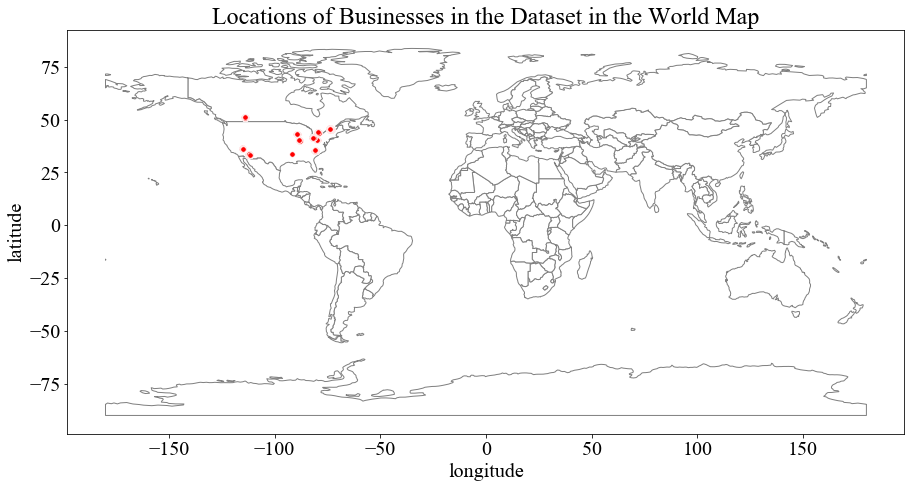

In [4]:
plt.rcParams['font.family'] =  "Times New Roman"
plt.rcParams['text.color'] = 'black'
plt.rcParams['font.size']=20
plt.rcParams['axes.labelcolor'] = 'black'
base = world_map.plot(edgecolor = 'grey', color = 'white', figsize=(15,10))
sns.scatterplot(x = "longitude", y = "latitude", data = bussiness_df, s = 30, color = 'red', ax = base)
plt.title('Locations of Businesses in the Dataset in the World Map')
plt.show()

We see all cities that contain business in the dataset are located in North America, in particular, the **United States** and **Canada**. From the world map, we can also see these cities are not widely spread in two contries, instead, they are concentrated in some parts. The next step is to find how many businesses are there in each country. The data set does not tell the country directly, but we can use the post code to determine country (Postcode in US has exactly five characters). I will use piechart to visualize them.

In [5]:
def group_by_country(df):
    country = []
    for index, row in df.iterrows():
        if len(row['postal_code'].strip()) == 5:
            country.append('United States')
        else:
            country.append('Canada')
    df['country'] = country

In [6]:
group_by_country(bussiness_df)

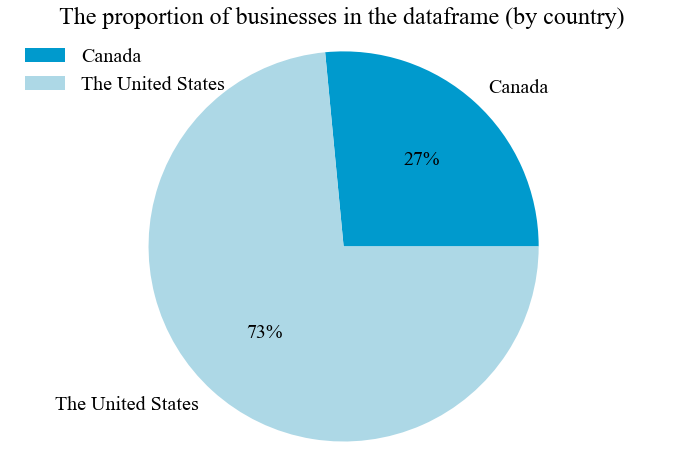

In [7]:
# Add a new column to the dataframe to indicate its country. 
fig, ax = plt.subplots(figsize=(12,8))
labels = ['Canada', 'The United States']
color_palette_list = ['#009ACD', '#ADD8E6']
# Generate data for the pie chart
Canada_Total = bussiness_df[bussiness_df['country'] == 'Canada'].shape[0]
United_States_Total = bussiness_df[bussiness_df['country'] == 'United States'].shape[0]
Total = bussiness_df.shape[0]
percentages = [Canada_Total / Total, United_States_Total / Total]
explode=(0.1,0)
ax.pie(percentages,  labels=labels,  
       colors=color_palette_list, autopct='%1.0f%%', 
       shadow=False, startangle=0)
ax.axis('equal')
ax.set_title("The proportion of businesses in the dataframe (by country)")
ax.legend(frameon=False)
plt.show()

From the piechart, we see about 3 quarters of businesses are located in the United States, rest of them are in Canada.
The next step is to figure out which states in these two countries contain those cities with businesses. Let's print out the list of the states first. Surprisingly, we find some states that do not have 2-letter-abbreviation. Obviously, they are not name of states in the US or Canada. Let's take a look of what is behind these states.

In [8]:
print("3-letter-abbreviation states:")
for name in list(bussiness_df.state.unique()):
    if len(name) != 2:
        print(name)

3-letter-abbreviation states:
BAS
XGM
XWY
CON
DUR
XGL
DOW


In [9]:
wrong_abbreviation_states = bussiness_df[((bussiness_df['state'] =='XGL') | (bussiness_df['state'] =='XGM') |
              (bussiness_df['state'] =='DUR') | (bussiness_df['state'] =='DOW') | (bussiness_df['state'] =='CON') |
             (bussiness_df['state'] =='BAS') | (bussiness_df['state'] =='XWY'))]

By looking at them carefully, we see there must be mistakes when recording these businesses. Since the states and cities indicate that they are European cities, but their latitudes and longitudes show that they are actually in US and Canada. Since the total length of our dataset is more than 190000, and wrong data only contain 11 businesses, so, dropping them will not affect the result too much, I will drop them for now.

In [10]:
# Delete wrong data
bussiness_df = bussiness_df[~((bussiness_df['state'] =='XGL') | (bussiness_df['state'] =='XGM') |
              (bussiness_df['state'] =='DUR') | (bussiness_df['state'] =='DOW') | (bussiness_df['state'] =='CON') |
             (bussiness_df['state'] =='BAS') | (bussiness_df['state'] =='XWY'))]
# Split it into two dataframes by country
Canada_bussiness_df = bussiness_df[bussiness_df['country'] == 'Canada']
United_States_bussiness_df = bussiness_df[bussiness_df['country'] == 'United States']

In [11]:
def avg_state_lattitude_longtitude(df, states, sorc):
    lattitude = []
    longitude = []
    for state in states:
        lattitude.append(df[df[sorc] == state][['latitude', 'longitude']].describe().loc['mean',][0])
        longitude.append(df[df[sorc] == state][['latitude', 'longitude']].describe().loc['mean',][1])
    return [lattitude, longitude]

In [12]:
top_10_states_us = pd.DataFrame(United_States_bussiness_df['state'].value_counts().head(10)).reset_index().rename(columns={"index": "state", "state": "counts"})
location = avg_state_lattitude_longtitude(United_States_bussiness_df, top_10_states_us.state, 'state')
top_10_states_us['latitude'] = location[0]
top_10_states_us['longitude'] = location[1]
top_3_states_ca = pd.DataFrame(Canada_bussiness_df['state'].value_counts().head(3)).reset_index().rename(columns={"index": "state", "state": "counts"})
location = avg_state_lattitude_longtitude(Canada_bussiness_df, top_3_states_ca.state, 'state')
top_3_states_ca['latitude'] = location[0]
top_3_states_ca['longitude'] = location[1]

In [13]:
us_map = world_map.query('name == "United States of America"')
cn_map = world_map.query('name == "Canada"')

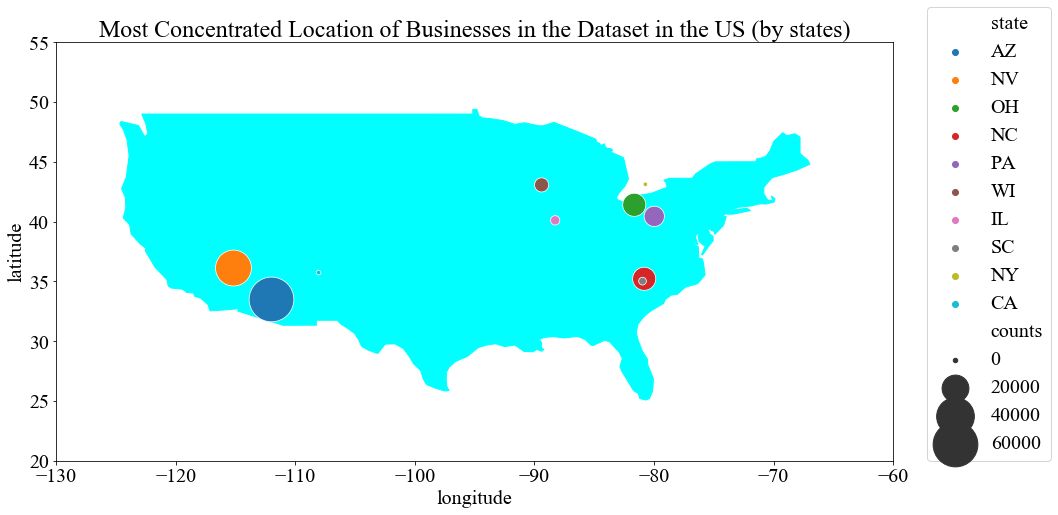

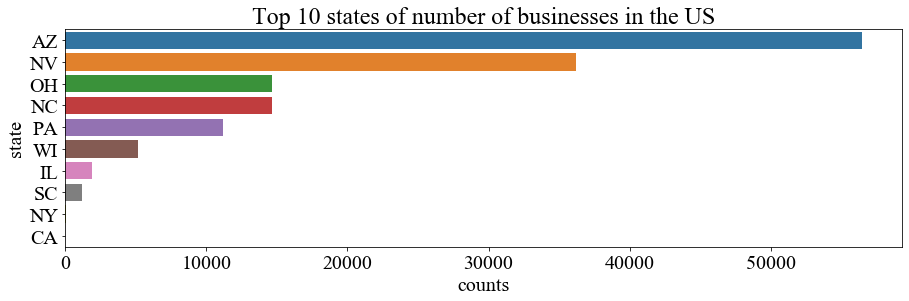

In [14]:
base = us_map.plot(edgecolor = 'cyan', color = 'cyan', figsize=(15,15))
ax = sns.scatterplot(x = "longitude", y = "latitude", data = top_10_states_us, color = 'red', hue = 'state',size = "counts", sizes = (20,2000), ax = base)
plt.xlim(-130, -60)
plt.ylim(20, 55)
plt.legend(loc=(1.04,0))
plt.title('Most Concentrated Location of Businesses in the Dataset in the US (by states)')
plt.show()
plt.figure(figsize = (15, 4))
sns.barplot(y = top_10_states_us.state, x= top_10_states_us.counts, orient = 'h')
plt.title('Top 10 states of number of businesses in the US')
plt.show()

From the map bar plot, and combine it with the map above, we see most bussinesses in the United States are concentrated in Northeastern and Southwestern United States. From the bar plot, we can clearly see that Arizona, Nevada, Ohio, North Dakota, Pennsylvania states have most of businesses in the dataset, the number of businesses recorded in Yelp exceeded 10000 in these states.

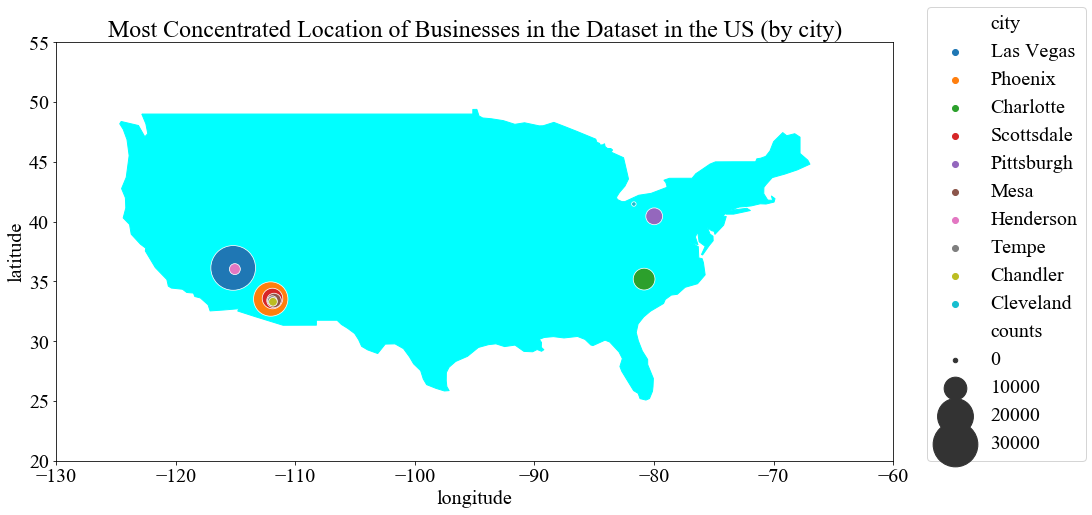

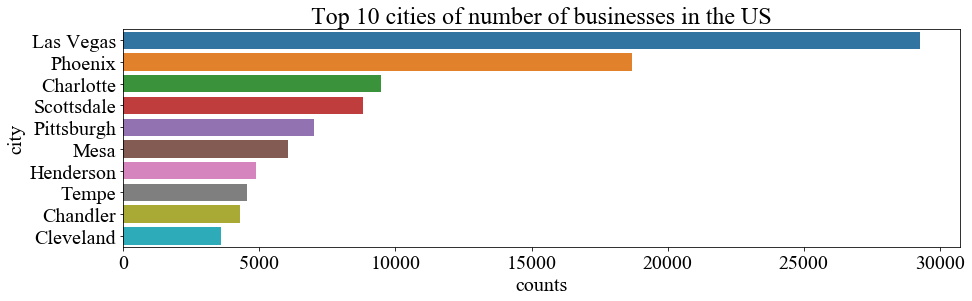

In [15]:
top_10_states_us = pd.DataFrame(United_States_bussiness_df['city'].value_counts().head(10)).reset_index().rename(columns={"index": "city", "city": "counts"})
location = avg_state_lattitude_longtitude(United_States_bussiness_df, top_10_states_us.city, 'city')
top_10_states_us['latitude'] = location[0]
top_10_states_us['longitude'] = location[1]
base = us_map.plot(edgecolor = 'cyan', color = 'cyan', figsize=(15,15))
ax = sns.scatterplot(x = "longitude", y = "latitude", data = top_10_states_us, color = 'red', hue = 'city',size = "counts", sizes = (20,2000), ax = base)
plt.xlim(-130, -60)
plt.ylim(20, 55)
plt.legend(loc=(1.04,0))
plt.title('Most Concentrated Location of Businesses in the Dataset in the US (by city)')
plt.show()
plt.figure(figsize = (15, 4))
sns.barplot(y = top_10_states_us.city, x= top_10_states_us.counts, orient = 'h')
plt.title('Top 10 cities of number of businesses in the US')
plt.show()

As for cities, we see Las Vegas has the most number of businesses, which is almost 30000. The city with the second largest number of businesses recorded in the US is Phoenix. Other cities in the US has less than 10000 businesses recorded in the dataset. Notice that many cities concentrated in Arizona in the Southwestern part of the US. These cities contribute a lot to the total number of businesses in Arizona. Next, take a look at Canada.

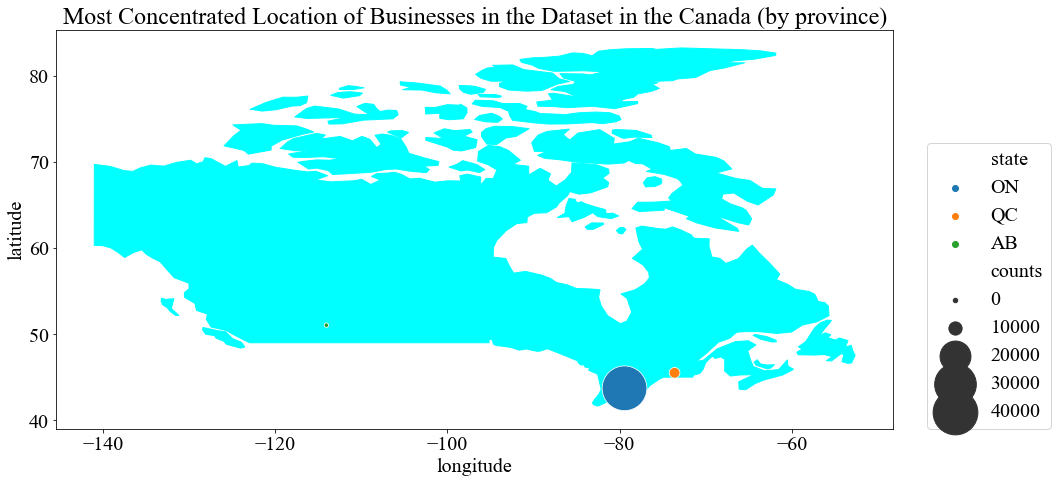

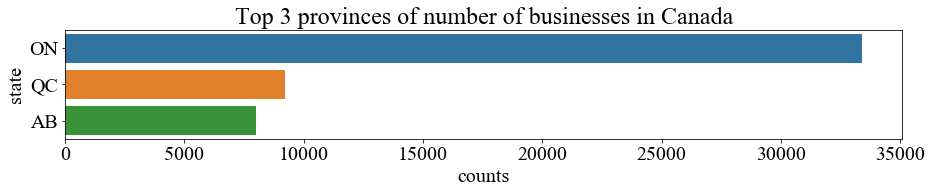

In [16]:
base = cn_map.plot(edgecolor = 'cyan', color = 'cyan', figsize=(15,15))
ax = sns.scatterplot(x = "longitude", y = "latitude", data = top_3_states_ca, color = 'red', hue = 'state',size = "counts", sizes = (20,2000), ax = base)
plt.legend(loc=(1.04,0))
plt.title('Most Concentrated Location of Businesses in the Dataset in the Canada (by province)')
plt.show()
plt.figure(figsize = (15, 2))
sns.barplot(y = top_3_states_ca.state, x= top_3_states_ca.counts, orient = 'h')
plt.title('Top 3 provinces of number of businesses in Canada')
plt.show()

In Canada, we see most cities are concentrated in Ontario, Québec, and Alberta. And Ontario takes up most of the businesses recorded in the dataset in Canada. Futhermore, we can see the 'average' location of businesses in Ontario is approxiamtely around Toronto.

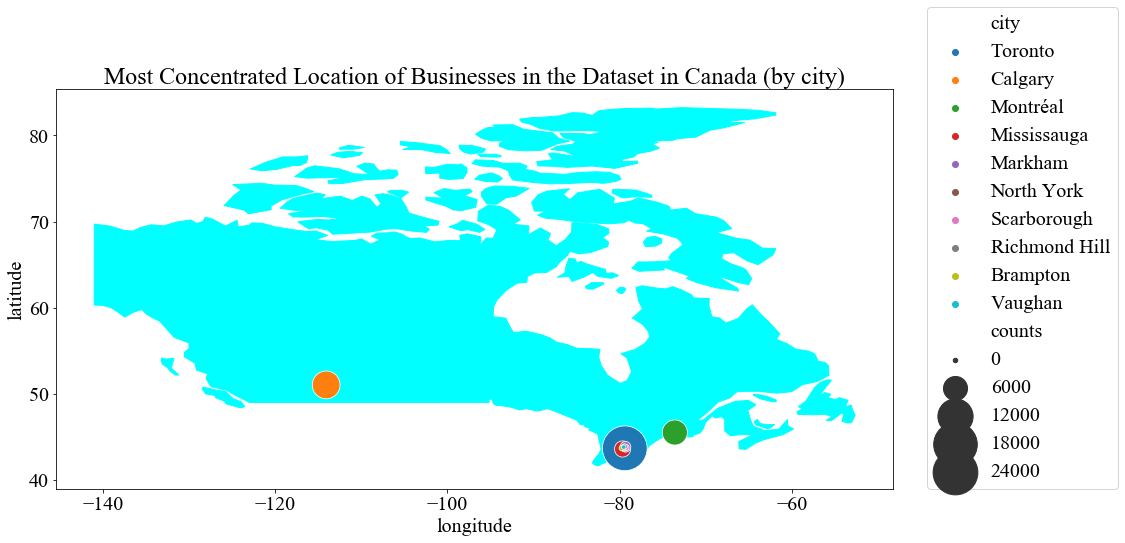

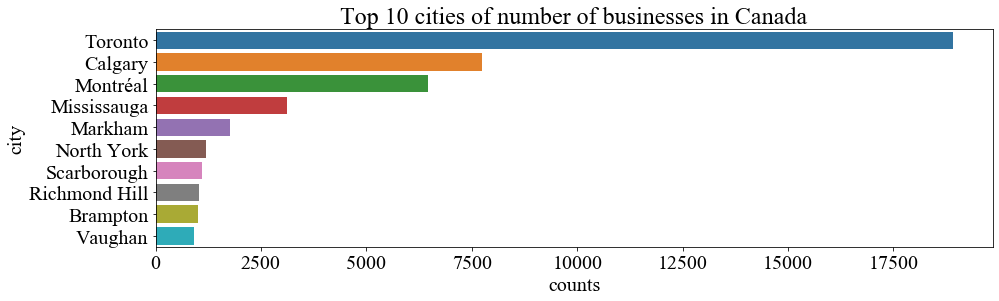

In [17]:
top_10_states_ca = pd.DataFrame(Canada_bussiness_df['city'].value_counts().head(10)).reset_index().rename(columns={"index": "city", "city": "counts"})
location = avg_state_lattitude_longtitude(Canada_bussiness_df, top_10_states_ca.city, 'city')
top_10_states_ca['latitude'] = location[0]
top_10_states_ca['longitude'] = location[1]
base = cn_map.plot(edgecolor = 'cyan', color = 'cyan', figsize=(15,15))
ax = sns.scatterplot(x = "longitude", y = "latitude", data = top_10_states_ca, color = 'red', hue = 'city',size = "counts", sizes = (20,2000), ax = base)
plt.legend(loc=(1.04,0))
plt.title('Most Concentrated Location of Businesses in the Dataset in Canada (by city)')
plt.show()
plt.figure(figsize = (15, 4))
sns.barplot(y = top_10_states_ca.city, x= top_10_states_ca.counts, orient = 'h')
plt.title('Top 10 cities of number of businesses in Canada')
plt.show()

For cities in Canada, we see except Calgary and Montréal, all top 10 cities are in GTA (great Toronto Areas). It would be interesting to take a look the characteristics of businesses in GTA in the next part since we have quite a lot information about this area.

#### the Pareto principle
Also, another interesting aspect to look at is **the Pareto principle**, that is 80% of the effects come from 20% of the causes. From the map, we see a large number businesses are concentrated in some specific regions. I will now investigate, does a few ctities contribute most number of businesses in this dataset.

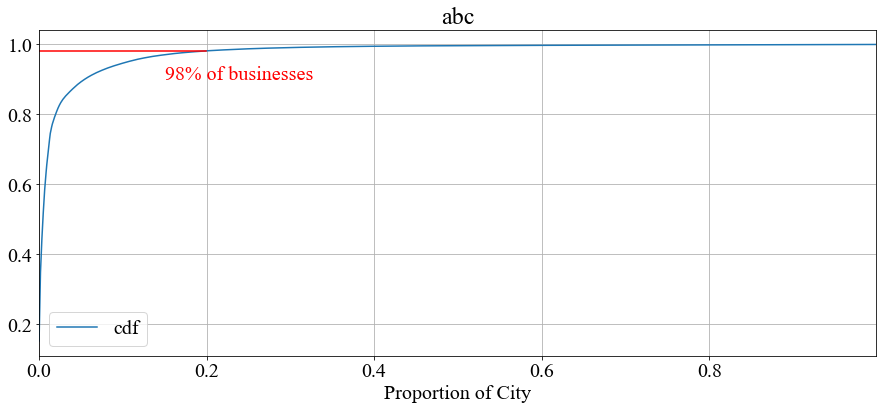

In [18]:
fig = plt.figure()
ax = fig.add_subplot()
cdf = bussiness_df.groupby('city')['city'].agg('count').pipe(pd.DataFrame).rename(columns = {'city': 'frequency'}).sort_values(by=['frequency'], ascending=False).reset_index()
cdf['Proportion of City'] = cdf.index 
cdf['Proportion of City'] = cdf['Proportion of City']/len(cdf)
cdf['pdf'] = cdf['frequency'] / sum(cdf['frequency'])
cdf['cdf'] = cdf['pdf'].cumsum()
cdf.plot(x = 'Proportion of City', y = ['cdf'], grid = True, figsize = (15,6), title = "abc", ax = ax)
ax.annotate('98% of businesses', (0.15,0.9), color = 'r')
ax.axhline(y=0.98,color='r',xmin=0, xmax=0.2)
plt.show()

Using plot of cumulative distribution function, we see 20% cities with the largest number of bussinesses contains more than 98% of bussinesses in the dataset. This implies our observations from the map.

### Category
#### The most frequent business categories.
The category of business is another important feature to investigate. A business may have several categories. (For example, a business may be recorded as both restaurant type and food type). We want to investigate the category to see what is the most common catrgory in this dataframe. First, let's look at how may combination of categories we have in the data set.
The procedure I will use is as the following:
1. Rearrange the category, count the frequency of each cateogory.
2. See if there is any big category, discuss the popularity of its subcategory.
The most intuitive way for us to view the allocation is through map. Using longititude and latitude provided in the dataset, we can plot locations of businesses in the dataset. 

In [19]:
print("There are", len(bussiness_df.categories.unique()), "combination of categories in this dataset.")

There are 93382 combination of categories in this dataset.


It is a huge number, so instead of counting the number of combinations of categories, we will count the apperance of each category in the dataset. (That is, if a business is of both food category and restaurant category, I will count both of them). 

In [20]:
def check_unique_category(df):
    category_dict = {}
    for index, row in df.iterrows():
        if None == row['categories']:
            continue
        else:
            for category in [i.strip() for i in row['categories'].split(',')]:
                if category not in category_dict:
                    category_dict[category] = 1
                else:
                    category_dict[category] = category_dict[category] + 1
    return category_dict

In [21]:
unique_category = check_unique_category(bussiness_df)
category_count = pd.DataFrame.from_dict(unique_category,orient='index')
category_count.columns = ['counts']
category_count.sort_values(by=['counts'], ascending=False, inplace = True)
category_count_top_10 = category_count.head(10)

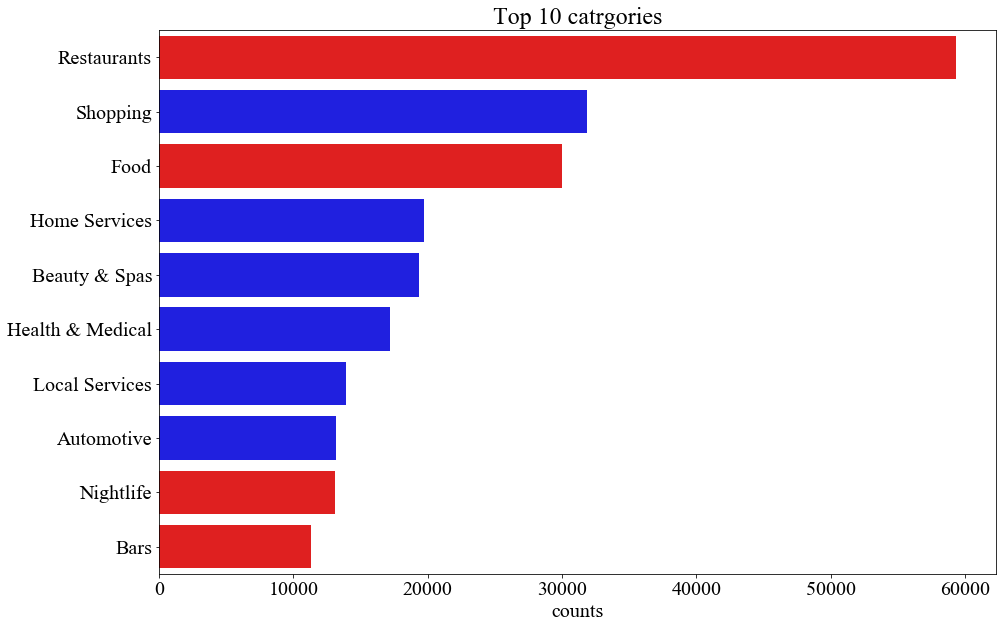

In [22]:
plt.figure(figsize = (15, 10))
sns.barplot(y = category_count_top_10.index, x= category_count_top_10.counts, orient = 'h', palette = ['red', 'blue', 'red', 'blue', 'blue', 'blue', 'blue', 'blue', 'red', 'red']  )
plt.title('Top 10 catrgories')
plt.show()

From the plot, we see restaurants are definitely the most frequent business in the datsset, we have more than 60000 restaurants in the dataset, which means about one thrid of the businesses are related to resuaurants. Shopping, and food categories follow restaurants. Notice that reaurants have some 'subcategories' are also in the list (for example, nightlife and bar). It would be better for us to split the data set into two parts, one is restaurant business, the other is "not restaurant" businesses. By doing this, we can have a better understanding of the popularity of different types of foods.

In [23]:
def check_restaurant(df):
    restaurant = []
    for index, row in df.iterrows():
        if None == row['categories']:
            restaurant.append(False)
        else:
            if 'Restaurants' in [i.strip() for i in row['categories'].split(',')]:
                restaurant.append(True)
            else:
                restaurant.append(False)
    df['restaurant'] = restaurant
def check_food(df):
    food = []
    for index, row in df.iterrows():
        if None == row['categories']:
            food.append(False)
        else:
            if 'Food' in [i.strip() for i in row['categories'].split(',')]:
                food.append(True)
            else:
                food.append(False)
    df['food'] = food

In [24]:
check_restaurant(bussiness_df)
check_food(bussiness_df)

In [25]:
without_resuaurant = bussiness_df[~bussiness_df['restaurant']]
resuaurant = bussiness_df[bussiness_df['restaurant']]
without_resuaurant_category = pd.DataFrame.from_dict(check_unique_category(without_resuaurant), orient='index')
without_resuaurant_category.columns = ['counts']
without_resuaurant_category.sort_values(by=['counts'], ascending=False, inplace = True)
without_resuaurant_category = without_resuaurant_category.head(10)

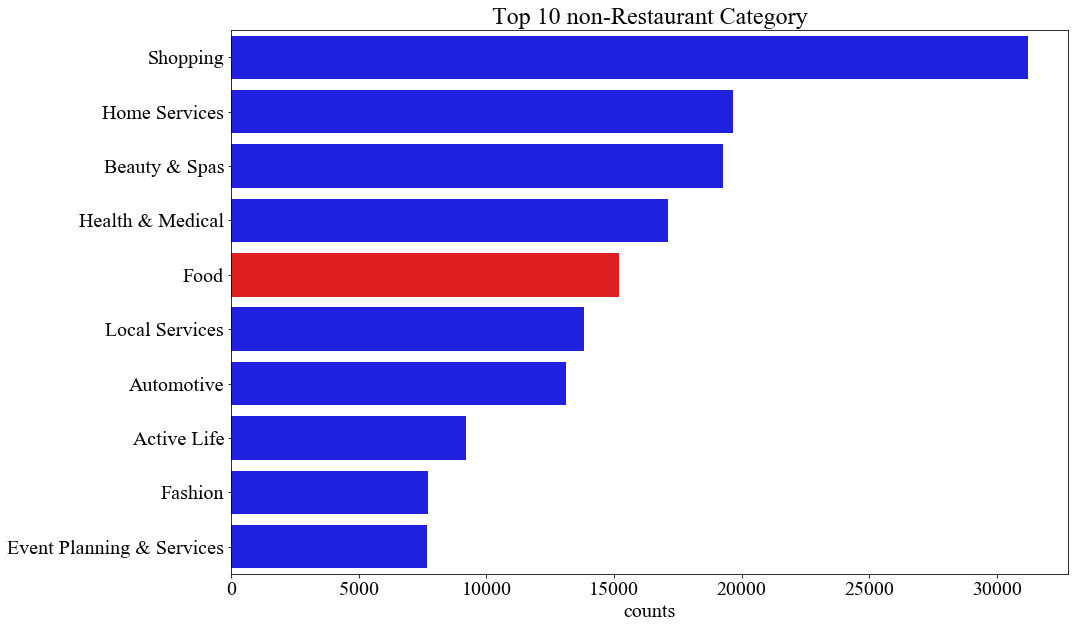

In [26]:
plt.figure(figsize = (15, 10))
sns.barplot(y = without_resuaurant_category.index, x= without_resuaurant_category.counts, orient = 'h', palette = ['blue', 'blue', 'blue', 'blue', 'red', 'blue', 'blue', 'blue', 'blue', 'blue'])
plt.title('Top 10 non-Restaurant Category')
plt.show()

Among all non-restaurants businesses, we see shopping catogory has the highest frequency. Home serivices, Beauty & Spas and Health & Medical also have the frequency higher than 15000, indicates that more than 1 percentage of bussinesses in this data set are related to these 3 categories. Notice that there are more than about 15000 businesses recorded as food but not restaurant in the dataset. And more interestigly, there are more than 40000 businesses are recored as restaurant but not food in their catrgory attribute. Let's take a look those restaurants that do not provide food, and food businesses that are not restarants.

Although these food businesses are not recorded as restaurants, the in the 'attributes' columnm, we find many of these businesses are all related to the word 'restaurant'. For instance, a business named "Japanese Specialties" (with business id IjGU7ZopsgeomsDQf20UXQ) is not a resaurant in its category column, but has attribute recorded as "RestaurantsPriceRange2': '2'..." which is a contradiction.
There is a limitation in the dataset, some are recorded restaurant but does have type restaurant.

In [27]:
pd.set_option('display.max_colwidth', -1)
bussiness_df[bussiness_df['business_id'] == 'irft4YkdNsww4DNf_Aftew'][['name','categories', 'attributes']]

,name,categories,attributes
33,So Cool Frozen Yogurt,"Juice Bars & Smoothies, Food, Ice Cream & Frozen Yogurt","{'BusinessAcceptsCreditCards': 'True', 'RestaurantsPriceRange2': '2', 'RestaurantsTakeOut': 'True', 'BikeParking': 'False', 'WiFi': ''free'', 'Caters': 'False', 'BusinessParking': '{'garage': False, 'street': False, 'validated': False, 'lot': False, 'valet': False}'}"


Similarly, it is also unreasonable to have restaurants not recorded as food category. This is a **limitation** in this dataset. The definition of each category is not clear and may overlap with each other (food vs. restaurant). The category attribute can be improved to a hierarchical organization to help users to read and benefit further data analysis.

In [28]:
%%html
<img src = 'structure.png', width = 800, height = 100>

By using hierarchical organization, a category cannot be paralleled with the its subcategory. This makes more sense for users.  For data analysis, when we count of businesses in each subcategory, we can just select all subcategory on that level. For example, comparing number of Chinese restaurant and Canadian(New) restaurant makes more sense than comparing grocery with Chinese restaurant.

In [29]:
resuaurant_category = pd.DataFrame.from_dict(check_unique_category(resuaurant), orient='index')
resuaurant_category.columns = ['counts']
resuaurant_category = resuaurant_category.sort_values(by=['counts'], ascending=False).drop(['Restaurants', 'Food'])
resuaurant_category_top_10 = resuaurant_category.head(10)

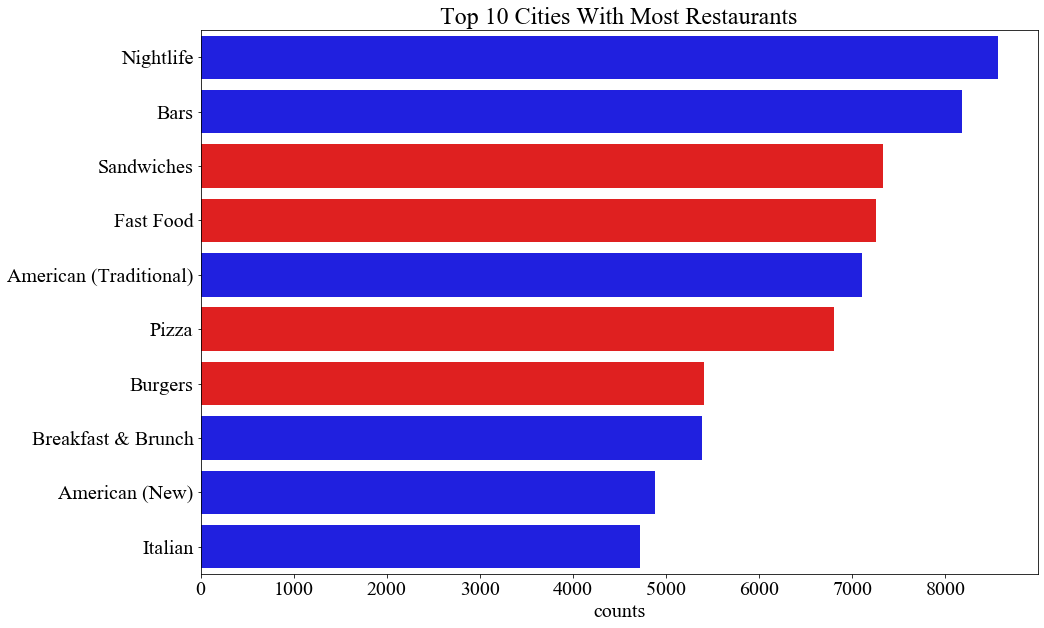

In [30]:
plt.figure(figsize = (15, 10))
sns.barplot(y = resuaurant_category_top_10.index, x= resuaurant_category_top_10.counts, orient = 'h', palette = ['blue', 'blue', 'red', 'red', 'blue', 'red', 'red', 'blue', 'blue', 'blue'])
plt.title('Top 10 Cities With Most Restaurants')
plt.show()

From the bar plot, we see the top 10 categories of restaurant types are evenly distributed. There is not a huge difference between two catrgories in terms of number of restaurants. Among all restaurants, nightlife and bar restaurants have the most number of businesses. Notice that fast food including pizza and burger is another category of restaurants that has a huge number.

### Convenience
#### What types of establishments tend to have higher bike parking.
The convenience of establisment is also an important thing to consider about for a bussiness. One important indicator of convenience is the bike parking facility of the establisment. So, I will implement further investigation on Bike Parking condition: **what types of establishments tend to have bike parking?**
I will discuss establisment in two ways, one is its **category**, the other is its **attribute** (Notice that a business may have multiple attributes, but I will count the occurance of them and find top 20 attributes with bike parking.)
The procedure I will use is as the following:
1. Rearrange the category, calculate the proportion of bike available businesses under this category. 
2. Rearrange the attribute, calculate the proportion of bike available businesses under this category.

In [31]:
def check_bike_parking(df):
    bike_parking = []
    for index, row in df.iterrows():
        if row['attributes'] == None:
            bike_parking.append(np.nan)
        else:
            if "BikeParking" in row['attributes']:
                if row['attributes']['BikeParking'] == 'True':
                    bike_parking.append(True)
                else:
                     bike_parking.append(False)
            else:
                bike_parking.append(False)
    return bike_parking

In [32]:
bussiness_df['Bike Parking Availability'] = check_bike_parking(bussiness_df)
bike_parking_available_df = bussiness_df[bussiness_df['Bike Parking Availability'] == True]
bike_parking_available_df.shape[0]
bike_parking_available = pd.DataFrame.from_dict(check_unique_category(bike_parking_available_df), orient='index')
bike_parking_available.shape[0]
bike_parking_available.columns = ['counts']
bike_parking_available.sort_values(by=['counts'], ascending=False, inplace = True)

In [33]:
bike_parking_ratio = pd.merge(category_count, bike_parking_available, left_index=True, right_index=True).reset_index().rename(columns={"counts_x": "Total Number", "counts_y": "Bike Available", "index": "category"})
bike_parking_ratio['ratio'] = bike_parking_ratio['Bike Available'] / bike_parking_ratio['Total Number']
popular_category_bike = bike_parking_ratio.head(10)

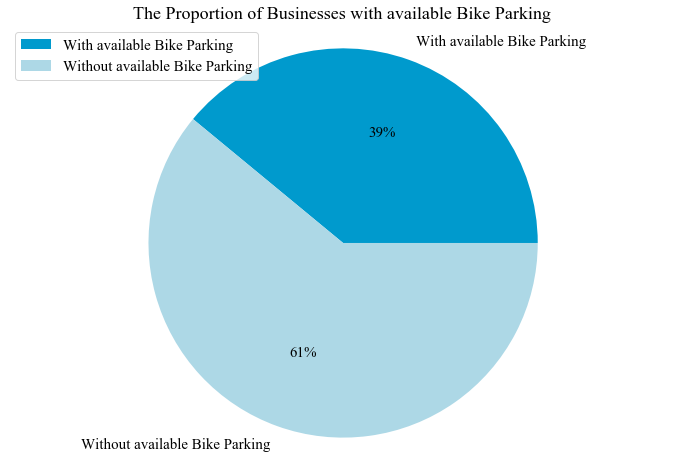

In [34]:
fig, ax = plt.subplots(figsize=(12,8))
plt.rcParams['font.family'] =  "Times New Roman"
plt.rcParams['text.color'] = 'black'
plt.rcParams['font.size']=15
labels = ['With available Bike Parking', 'Without available Bike Parking']
color_palette_list = ['#009ACD', '#ADD8E6']
# Generate data for the pie chart
total_ratio = sum(bike_parking_ratio['Bike Available']) / sum(bike_parking_ratio['Total Number'])
Total = bussiness_df.shape[0]
percentages = [total_ratio, 1 - total_ratio]
explode=(0.1,0)
ax.pie(percentages,  labels=labels,  
       colors=color_palette_list, autopct='%1.0f%%', 
       shadow=False, startangle=0)
ax.axis('equal')
ax.set_title("The Proportion of Businesses with available Bike Parking")
ax.legend(loc='upper left')
plt.show()

From the piechart, we see about 40% of businesses clearly indicate they provide bike parking in their establishments. As we discusses above, this data may be **inaccurate and ambiguous**. Since some establiments may not provide bike parking themselves, but there maybe public facilities with available bike parking.

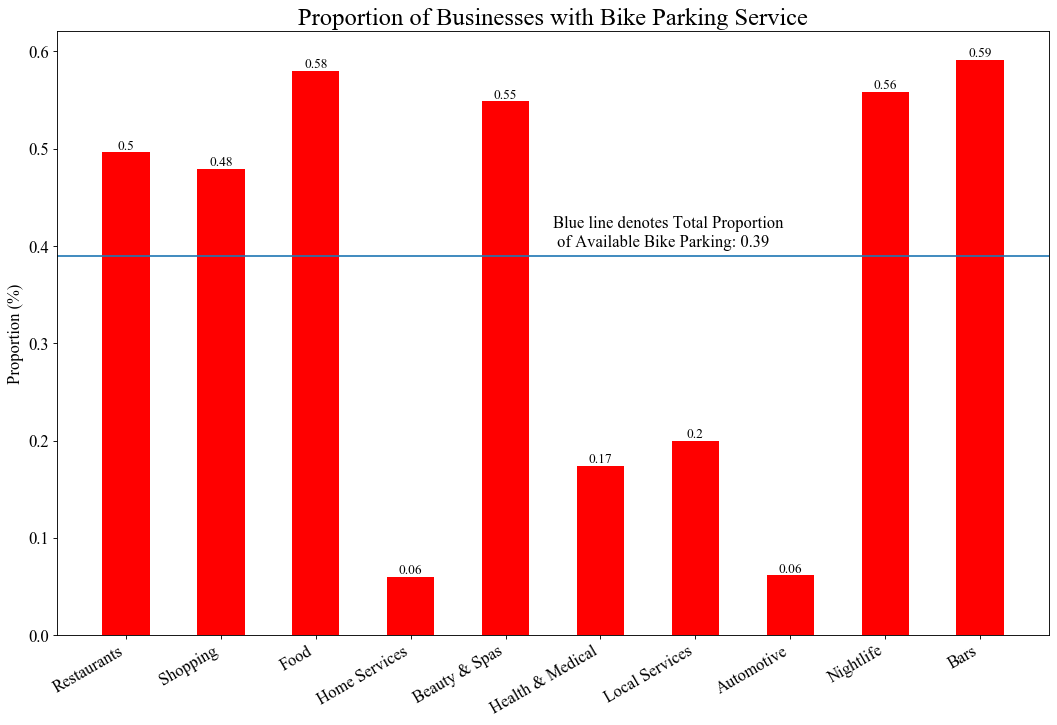

In [35]:
all_colors = list(plt.cm.colors.cnames.keys())
plt.figure(figsize=(16,10), dpi= 80)
plt.bar(popular_category_bike['category'], popular_category_bike['ratio'], color='red', width=.5)
for i, val in enumerate(popular_category_bike['ratio'].values):
    plt.text(i, val, round(float(val),2), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':12})
plt.axhline(0.39)
plt.annotate('Blue line denotes Total Proportion\n of Available Bike Parking: 0.39', (4.5,0.4), color = 'black')
plt.title("Proportion of Businesses with Bike Parking Service", fontsize=22)
plt.xticks(rotation=30,ha='right')
plt.ylabel('Proportion (%)')
plt.show()

From the bar plot above, we clearly see **restaurant** and its subcategories nightlife, bar generally have a higher proportion of available bike parking service than the average proportion for all bussiness. On the other hand, **home services and automative** categories only have about 6% of its businesses provide bike parking service. This is reasonable, customers will probably go to automotive by bike.

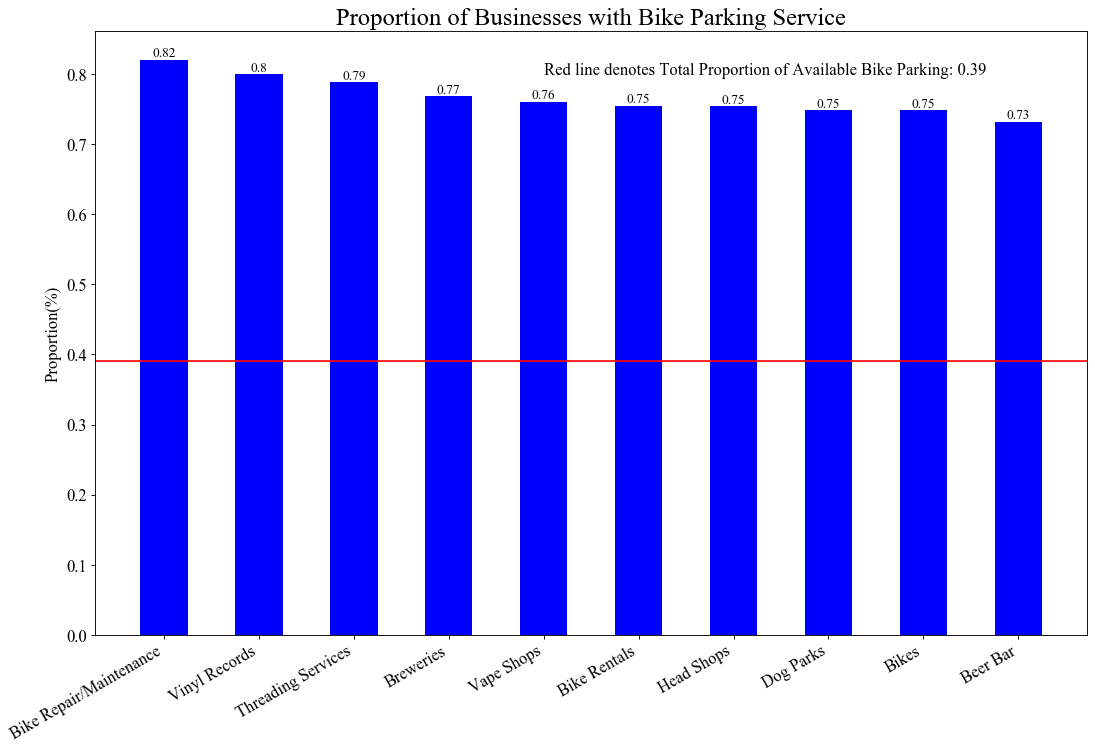

In [36]:
popular = bike_parking_ratio[bike_parking_ratio['Total Number'] > bike_parking_ratio['Total Number'].quantile(0.5)].sort_values(by=['ratio'], ascending=False).head(10)
plt.figure(figsize=(16,10), dpi= 80)
plt.bar(popular['category'], popular['ratio'], color='blue', width=.5)
for i, val in enumerate(popular['ratio'].values):
    plt.text(i, val, round(float(val),2), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':12})
plt.axhline(0.39, color = 'red')
plt.title("Proportion of Businesses with Bike Parking Service", fontsize=22)
plt.annotate('Red line denotes Total Proportion of Available Bike Parking: 0.39', (4,0.8), color = 'black')
plt.xticks(rotation=30,ha='right')
plt.ylabel('Proportion(%)')
plt.show()

For all all categories (with number of businesses more than 50 percentile), I sort them by bike parking availability proportion and then find top 10 categories with the highest proportion. Not surprisingly, Bike Repair/Maintenance category has the highest proportion. And other bike related categories such as bike rentals and bikes also have high proporation more than 70%. While, it is interesting to see Beer Bar has a high of proportion of bike parking availability. From my point of view, this is because it is illegal to drive a car when driking too much alcohol.

In [37]:
def check_attributes(df):
    attributes_count = {}
    for index, row in df.iterrows():
        if row['attributes'] == None:
            continue
        else:
            for key in row['attributes'].keys():
                value = row['attributes'][key]
                if '{' not in value:
                    newkey = (key, value)
                    if newkey not in attributes_count:
                        attributes_count[newkey] = 1
                    else:
                        attributes_count[newkey] += 1
                else:
                    sub_dict = ast.literal_eval(value)
                    for subkey in sub_dict:
                        newkey = (key+' '+subkey, sub_dict[subkey])
                        if newkey not in attributes_count:
                            attributes_count[newkey] = 1
                        else:
                            attributes_count[newkey] += 1
    return attributes_count
attributes_count = check_attributes(bike_parking_available_df)
attributes = [i[0] for i in list(attributes_count.keys())]
values =  [i[1] for i in list(attributes_count.keys())]
counts = [i for i in list(attributes_count.values())]
attributes_count_df = pd.DataFrame({"attributes": attributes, "values": values, "counts":counts})
attributes_count_df = attributes_count_df.sort_values(by=['counts'], ascending=False)


In [38]:
attributes_total = check_attributes(bussiness_df)
attributes = [i[0] for i in list(attributes_total.keys())]
values =  [i[1] for i in list(attributes_total.keys())]
counts = [i for i in list(attributes_total.values())]
attributes_total_df = pd.DataFrame({"attributes": attributes, "values": values, "counts":counts})

In [39]:
ratio_df = pd.merge(attributes_total_df, attributes_count_df,  how='right', left_on=['attributes','values'], right_on = ['attributes','values'])
ratio_df['ratio'] = ratio_df['counts_y'] / ratio_df['counts_x']

In [40]:
popular_attribute = ratio_df[ratio_df['counts_x']>ratio_df['counts_x'].quantile(0.5)].sort_values(by=['ratio'], ascending=False).head(10)

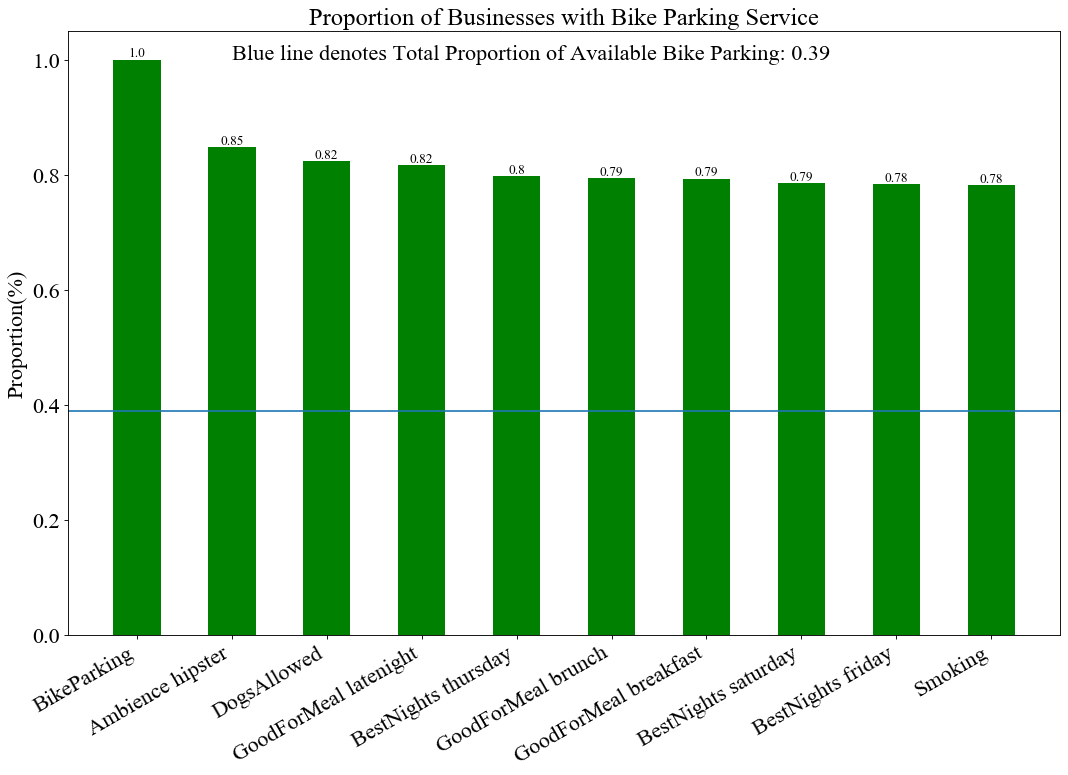

In [162]:
plt.figure(figsize=(16,10), dpi= 80)
plt.bar(popular_attribute['attributes'], popular_attribute['ratio'], color='green', width=.5)
for i, val in enumerate(popular_attribute['ratio'].values):
    plt.text(i, val, round(float(val),2), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':12})
plt.axhline(0.39)
plt.xticks(rotation=30,ha='right')
plt.annotate('Blue line denotes Total Proportion of Available Bike Parking: 0.39', (1,1), color = 'black')
plt.title("Proportion of Businesses with Bike Parking Service", fontsize=22)
plt.ylabel('Proportion(%)')
plt.show()

Attribute column is another perspective to look at. From the bar plot, we see despite bike parking attribute, **Amience Hipster** is another attribute with high proportion of bike parking availability. This is a newly added attribute in Yelp business data set. I will do a further explortaion here. According to [scoopwhoop](https://www.scoopwhoop.com/hipster-restaurants/), "Hipster" is a subculture which emphasizes style, authenticity and uniqueness. And by [previous studies](https://web.archive.org/web/20131031085525/http://m.theatlanticwire.com/national/2012/01/fixie-index-places-most-entranced-hipster-trends/47527/), Single-speed bicycle with rear coaster brake is a symbol of this culture. (Below is an example), therefore, it is reasonble that Hipster restaurants have a high proportion of available bike facility.

In [42]:
%%html
<img src = 'bike.jpg', width = 800, height = 100>

As we discussed above, bike parking availability is an indicator of the convenience of a establishment. So the last question I want to invesigate about the bike parking availability is **Does proportion of bike parking Availability relate to star evualtion for a businesses?**
My approach for this question is to group the businesses in terms of their star eveluation and find the proportion of establishments with available bike parking facility for each star. Then use line plot to visualize the the relationship using line plot.

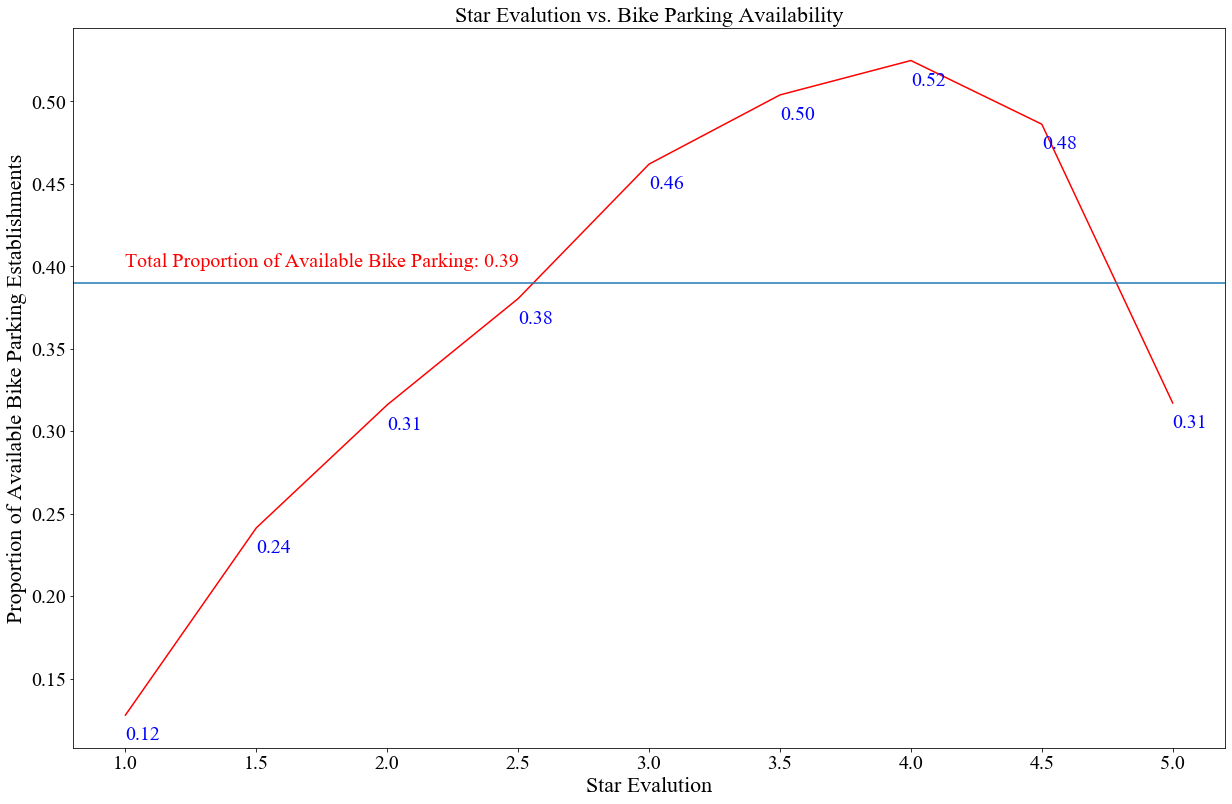

In [163]:
drop = bussiness_df.dropna().astype({'Bike Parking Availability': 'int32'})
star_count_bike = drop.groupby('stars').mean()['Bike Parking Availability']
stars = list(star_count_bike.index)
availability  = list(star_count_bike)
fig = plt.figure(figsize=(16,10))
ax = fig.add_axes([0,0,1,1])
ax.plot(stars, availability, color='red')
ax.annotate('Total Proportion of Available Bike Parking: 0.39', (1,0.4), color = 'r')
for i in range(0, 9):
    a = str(list(star_count_bike)[i])[0:4]
    b = (list(star_count_bike.index))[i]
    c = (list(star_count_bike))[i]
    ax.annotate(a, (b, c-0.015), color = 'b')
plt.axhline(0.39)
plt.xlabel('Star Evalution',  fontsize=22)
plt.ylabel('Proportion of Available Bike Parking Establishments',  fontsize=22)
plt.title('Star Evalution vs. Bike Parking Availability',  fontsize=22)
plt.show()

The line plot does tell us there is a positive relationship between star evaluation and availability of bike parking for an establishment. For establishments with a higher star evalution, the proportion of available bike parking facility of establishments (with that evaluation) increases as well (Notice that I am not concluding a causing relationship, but an **association**). However, when star evaluation is greater than 4.0, the proportion of available bike parking establishments decrease. This indicates that for a business to be **successful** (evaluation greater than 4), the convenience of the business matters, but for a business to be **outstanding** (evaluation reaches 5), there maybe other more important aspects to look at.

### Reviews and Rating

#### Initial Guess
According to an article that was published recently, having more yelp reviews result in a higher rating, and this helps increase the sales indirectly. Using the dataset we have, we can investigate this relationship deeper than random guessing. Let's first take a look at two attributes.

#### Procedure
The standard deviation(110.1) for review counts is of greater magnitude than its mea(33.5)n can indicate that there may be several outliers with very high review counts (also because of mean is higher than median value of this attribute). Therefore, the correlation of these two variables may be deeply influenced by those outliers. However, the restaurants with extremely high review counts are also important to our result, so we can not just simply drop them.

So the procedure I chose for this question is through arrange 'review_count' attribute into 5 categorical value:

0 to 20(th)percentile, 20 to 40(th)percentile, 40 to 60(th)percentile, 60 to 80(th)percentile, 80 to 100(th)percentile. 


And combine 'stars' attribute into 5 categorical variable:

1.0 to 1.5 star, 2.0 to 2.5 star, 3.0 to 3.5 star,  4.0 to 4.5 star, 5.0 star. And visualize the relationship using stacked bar plot.

In [44]:
percentile_20 = bussiness_df['review_count'].quantile(.2)
percentile_40 = bussiness_df['review_count'].quantile(.4)
percentile_60 = bussiness_df['review_count'].quantile(.6)
percentile_80 = bussiness_df['review_count'].quantile(.8)

In [45]:
def group_by_percentile(df, percentile_20, percentile_40, percentile_60, percentile_80):
    percentile = []
    for index, row in df.iterrows():
        if row['review_count'] > percentile_80:
            percentile.append('80_percentile')
        elif row['review_count'] > percentile_60:
            percentile.append('60_percentile')
        elif row['review_count'] > percentile_40:
            percentile.append('40_percentile')
        elif row['review_count'] > percentile_20:
            percentile.append('20_percentile')
        else:
            percentile.append('0_percentile')
    return percentile

In [46]:
bussiness_df['review_count_percentile'] = group_by_percentile(bussiness_df, percentile_20, percentile_40, percentile_60, percentile_80)

In [47]:
star_review = bussiness_df[['stars', 'review_count_percentile']]

In [48]:
def group_star_review(df):
    return [df[(df['stars'] >= 1.0) & (df['stars'] < 2.0)].shape[0], 
                 df[(df['stars'] >= 2.0) & (df['stars'] < 3.0)].shape[0],
                 df[(df['stars'] >= 3.0) & (df['stars'] < 4.0)].shape[0],
                 df[(df['stars'] >= 4.0) & (df['stars'] < 5.0)].shape[0],
                 df[(df['stars'] >= 5.0)].shape[0]]

In [49]:
percentile_0 = group_star_review(star_review[star_review['review_count_percentile'] == '0_percentile'])
percentile_20  = group_star_review(star_review[star_review['review_count_percentile'] == '20_percentile'])
percentile_40 = group_star_review(star_review[star_review['review_count_percentile'] == '40_percentile'])
percentile_60 =  group_star_review(star_review[star_review['review_count_percentile'] == '60_percentile'])
percentile_80 =  group_star_review(star_review[star_review['review_count_percentile'] == '80_percentile'])

The chart indicates that the business above 80 has a different trend of, let'a apply the same procedure to see if there is a different relationship.

In [50]:
above_80_percentile = bussiness_df[bussiness_df['review_count_percentile'] == '80_percentile']
above_80_percentile_20 = above_80_percentile['review_count'].quantile(.2)
above_80_percentile_40 = above_80_percentile['review_count'].quantile(.4)
above_80_percentile_60 = above_80_percentile['review_count'].quantile(.6)
above_80_percentile_80 = above_80_percentile['review_count'].quantile(.8)
above_80_percentile['above_80_review_count_percentile'] = group_by_percentile(above_80_percentile, above_80_percentile_20,
                                                                              above_80_percentile_40, above_80_percentile_60, above_80_percentile_80)
above_80_percentile_star_review = above_80_percentile[['stars', 'above_80_review_count_percentile']]

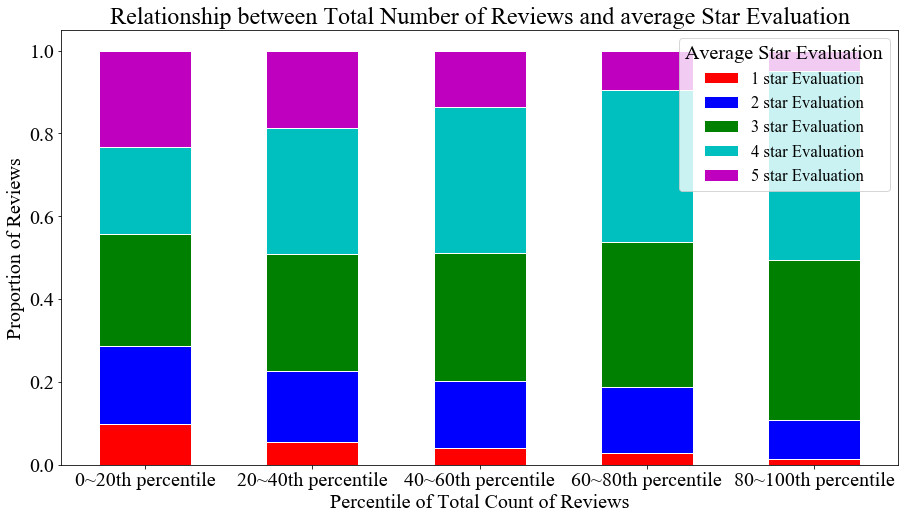

In [51]:
# Data
r = [0,1,2,3,4]
plt.figure(figsize=(15,8))
percentile_0 = group_star_review(star_review[star_review['review_count_percentile'] == '0_percentile'])
percentile_20 = group_star_review(star_review[star_review['review_count_percentile'] == '20_percentile'])
percentile_40 = group_star_review(star_review[star_review['review_count_percentile'] == '40_percentile'])
percentile_60 =  group_star_review(star_review[star_review['review_count_percentile'] == '60_percentile'])
percentile_80 =  group_star_review(star_review[star_review['review_count_percentile'] == '80_percentile'])
# From raw value to percentage
totals = [sum(percentile_0), sum(percentile_20), sum(percentile_40), sum(percentile_60), sum(percentile_80)]
star = []
for i in range(0,5):
    star.append([percentile_0[i] / totals[0], percentile_20[i] / totals[1], percentile_40[i] / totals[2], percentile_60[i] / totals[3], percentile_80[i] / totals[4]])
plt.rcParams['font.size']=20
# plot
barWidth = 0.55
names = ('0~20th percentile','20~40th percentile','40~60th percentile','60~80th percentile','80~100th percentile')
plt.bar(r, star[0], color='r', edgecolor='white', width=barWidth, label  ='1 star Evaluation')
plt.bar(r, star[1], bottom=star[0], color='b', edgecolor='white', width=barWidth, label  ='2 star Evaluation')
plt.bar(r, star[2], bottom=[i+j for i,j in zip(star[0], star[1])], color='g', edgecolor='white', width=barWidth,label= '3 star Evaluation')
plt.bar(r, star[3], bottom=[i+j+k for i,j,k in zip(star[0], star[1], star[2])], color='c', edgecolor='white', width=barWidth, label='4 star Evaluation')
plt.bar(r, star[4], bottom=[i+j+k+u for i,j,k,u in zip(star[0], star[1], star[2], star[3])], color='m', edgecolor='white', width=barWidth, label='5 star Evaluation')

# Custom x axis
plt.xticks(r, names)
plt.xlabel("Percentile of Total Count of Reviews")
plt.legend(title="Average Star Evaluation", loc='upper right',fontsize = 'small')
plt.ylabel("Proportion of Reviews")
plt.title("Relationship between Total Number of Reviews and average Star Evaluation")
# Show graphic
plt.show()

From the stacked bar plot, we first take a look the area of red rectangles in different bars. The area of red rectangle has a decreasing trend, which indicates that along with the increase of number of reviews, the proportion of 1 star evaluation decreses. Surprisingly, there is a similar trend for purple rectangle. Therefore, we may conclude that for businesses with more number of reviews, its proportion of extreme high or low evaluation decrease. This is reasonable, think about it using analogy of 'the Law of Large Number', more reviews a business has, the mean of its evalution stars should get closer the expectation (in this case, the expectation is around 3-4 stars).

The area of cyan-blue rectangle increases along with the number of reviews. Which implies that there is a postive association between number of 4 star evaluation and the total review counts of a business. This does not help statement in the article directly, but does depicts the relationship between star evaluation and number of reviews.

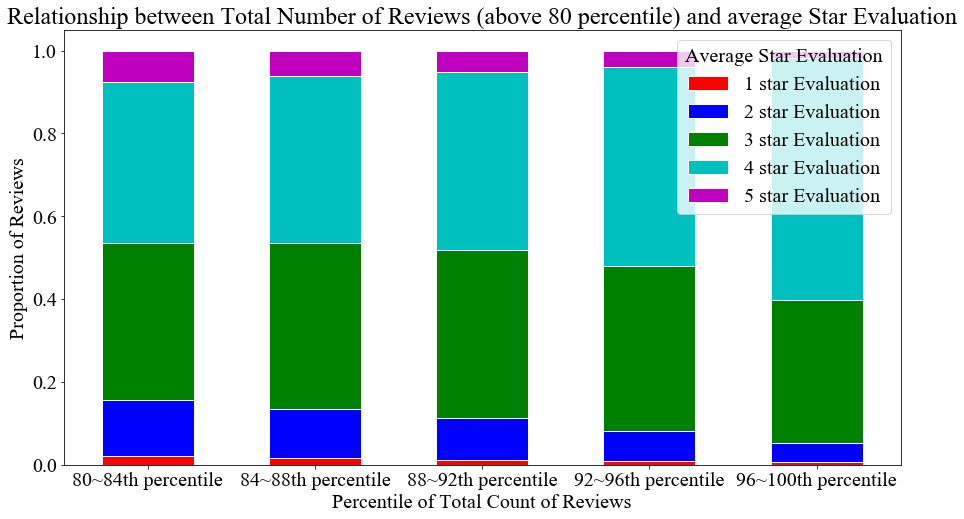

In [52]:
# Data
r = [0,1,2,3,4]
plt.figure(figsize=(15,8))
percentile_0 = group_star_review(above_80_percentile_star_review[above_80_percentile_star_review['above_80_review_count_percentile'] == '0_percentile'])
percentile_20 = group_star_review(above_80_percentile_star_review[above_80_percentile_star_review['above_80_review_count_percentile'] == '20_percentile'])
percentile_40 = group_star_review(above_80_percentile_star_review[above_80_percentile_star_review['above_80_review_count_percentile'] == '40_percentile'])
percentile_60 =  group_star_review(above_80_percentile_star_review[above_80_percentile_star_review['above_80_review_count_percentile'] == '60_percentile'])
percentile_80 =  group_star_review(above_80_percentile_star_review[above_80_percentile_star_review['above_80_review_count_percentile'] == '80_percentile'])
# From raw value to percentage
totals = [sum(percentile_0), sum(percentile_20), sum(percentile_40), sum(percentile_60), sum(percentile_80)]
star = []
plt.rcParams['font.size']=20
for i in range(0,5):
    star.append([percentile_0[i] / totals[0], percentile_20[i] / totals[1], percentile_40[i] / totals[2], percentile_60[i] / totals[3], percentile_80[i] / totals[4]])

# plot
barWidth = 0.55
names = ('80~84th percentile','84~88th percentile','88~92th percentile','92~96th percentile','96~100th percentile')
plt.bar(r, star[0], color='r', edgecolor='white', width=barWidth, label  ='1 star Evaluation')
plt.bar(r, star[1], bottom=star[0], color='b', edgecolor='white', width=barWidth, label  ='2 star Evaluation')
plt.bar(r, star[2], bottom=[i+j for i,j in zip(star[0], star[1])], color='g', edgecolor='white', width=barWidth,label= '3 star Evaluation')
plt.bar(r, star[3], bottom=[i+j+k for i,j,k in zip(star[0], star[1], star[2])], color='c', edgecolor='white', width=barWidth, label='4 star Evaluation')
plt.bar(r, star[4], bottom=[i+j+k+u for i,j,k,u in zip(star[0], star[1], star[2], star[3])], color='m', edgecolor='white', width=barWidth, label='5 star Evaluation')


# Custom x axis

plt.xticks(r, names)
plt.xlabel("Percentile of Total Count of Reviews")
plt.legend(title="Average Star Evaluation", loc='upper right')
plt.ylabel("Proportion of Reviews")
plt.title("Relationship between Total Number of Reviews (above 80 percentile) and average Star Evaluation")
 
# Show graphic
plt.show()

Since, we know there are businesses with extremely high number of reviews, the relationship may look different for these businesses. So I use a seperate stacked bar plot to visualize the relationship between review counts and star evaluation when review counts is extremely high (higher than 80th percentile). The approach is similar as before. And trend is similar as well, we can see from 96th to 100th percentile of review counts, there are more than half of evaluations are 4 stars. Therefore, for extreme cases, the relationship is similar as normal cases.

In [53]:
star_count_review = drop.groupby('stars').mean()['review_count']

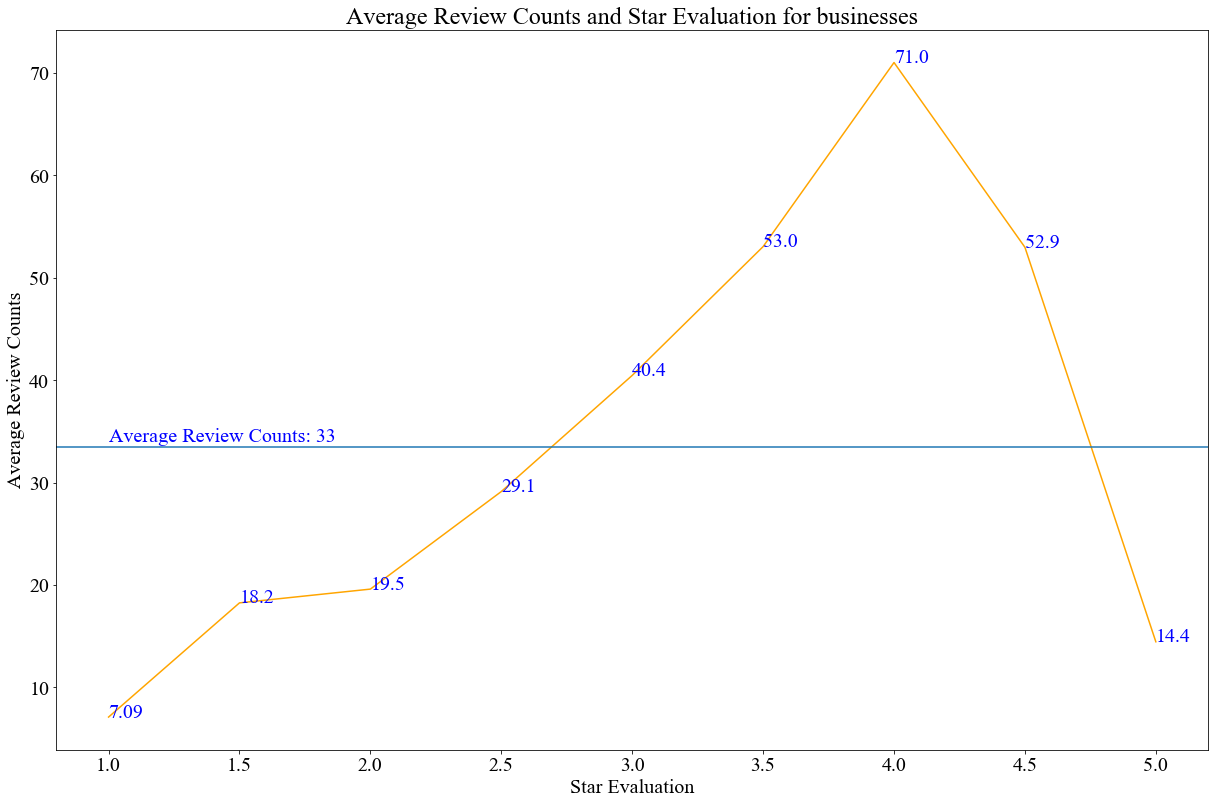

In [54]:
stars = list(star_count_review.index)
availability  = list(star_count_review)
fig = plt.figure(figsize=(16,10))
ax = fig.add_axes([0,0,1,1])
ax.plot(stars, availability, color='orange')
ax.annotate('Average Review Counts: 33', (1,34), color = 'b')
for i in range(0, 9):
    a = str(list(availability)[i])[0:4]
    b = (list(stars))[i]
    c = (list(availability))[i]
    ax.annotate(a, (b, c-0.015), color = 'b')
plt.axhline(33.5)
plt.xlabel('Star Evaluation')
plt.ylabel('Average Review Counts')
plt.title('Average Review Counts and Star Evaluation for businesses')
plt.show()

Lastly, we plot a lineplot to visualize the relationship between star evalution and review counts for businesses. Comparing to the stacked bar plot, we reverse x-axis and y-axis in this case. We can clearly see that for all businesses with 4 stars evalution, they have the most number of average review counts, about 71.0. This means more reviews a business has, the more likely for it to be evaluated at 4 star. 

## Characteristics of GTA Businesses
From the previous part, we see there are many businesses located in GTA. It is always useful to go from overall to a partition of the dataset. Since we lived in GTA, it became more interetsing to take a look at the neighborhood from a new perspetive. So, in this part, I will focus on businesses in GTA, and make connection between them to the all the businesses dataset.
Firstly, I want to filter bussiness that are located in Ontario to get a dataframe only contains GTA businesses.
### GTA data
From the map, we see most of the data are located in the GTA. While, there is one bussiness located at the right side of Ontario. I will drop it to form a dataframe only contains bussinesses in the GTA.

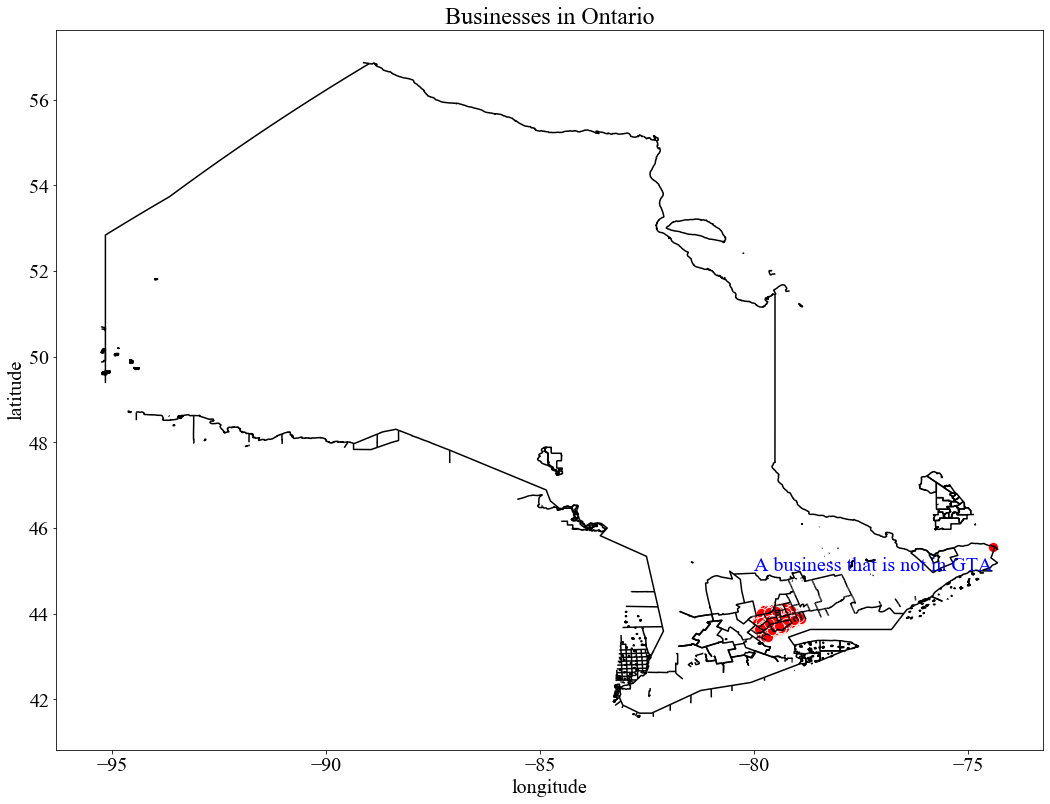

In [55]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_axes([0,0,1,1])
ontario_map = geopd.read_file("ontario_administrative/ontario_administrative.shp")
ontario_map.plot(edgecolor = 'black', color = 'black', figsize=(15,10), ax = ax)
sns.scatterplot(x = "longitude", y = "latitude",  data = bussiness_df[bussiness_df['state'] == 'ON']  , s = 100, ax=ax, color = 'red' )
ax.annotate('A business that is not in GTA', (-80,45), color = 'b')
plt.title('Businesses in Ontario')
plt.show()

In [56]:
# Remove the outlier
GTA_business_df  = bussiness_df[(bussiness_df['state'] == 'ON') & (bussiness_df['longitude'] < -76)]

### Category


#### The Whole vs. The Part
In the last part, we investigated the popularity of categories in the whole data frame. However, we know Toronto is a special city with its unique characteristics in all ways. It is interesting to do a "the whole and the part" comparision for this topic. If the popular categories are different in Toronto, we may also look deeper into what is behind this difference.

#### Procedure
The procedure I will follow for this question is roughly:
1. Find top 10 frequent categories in GTA, compare it with the result of the whole dataset.
2. Find top 10 restaurant categories in GTA, compare it with the result of the whole dataset.
3. Apply further investigation on the reason behind difference/similarity.

In [57]:
GTA_category = pd.DataFrame.from_dict(check_unique_category(GTA_business_df), orient='index')
GTA_category.columns = ['counts']
GTA_category.sort_values(by=['counts'], ascending=False, inplace = True)
GTA_category_top10 = GTA_category.head(10)
GTA_category["ranking_GTA"] = [i for i in range(1, GTA_category.shape[0]+1)]
category_count["ranking_All"] = [i for i in range(1, category_count.shape[0]+1)]
category_rank = pd.merge(GTA_category, category_count, left_index=True, right_index=True)
category_rank['Difference'] = -(category_rank['ranking_GTA']- category_rank['ranking_All'] )

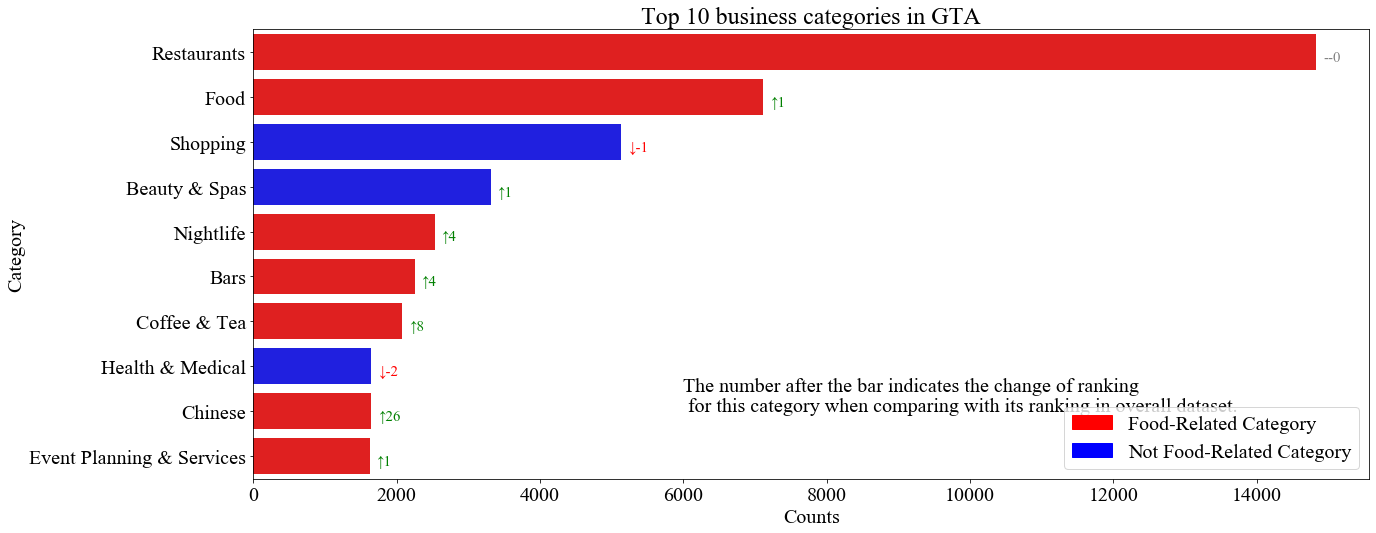

In [58]:
fig = plt.figure()
ax = fig.add_subplot()
fig.set_size_inches(20, 8.27)
sns.barplot(y = GTA_category_top10.index, x= GTA_category_top10.counts, orient = 'h', ax = ax, palette =['r','r','b','b','r','r','r','b','r','r'])
for a, r in enumerate(ax.patches):
    d = category_rank['Difference'][a] 
    if d > 0:
        t = "\u2191" + str(d)
        ax.text(r.get_width()+100, r.get_y()+0.6, t, size=15, color= 'green')
    elif d < 0:
        t = "\u2193" + str(d)
        ax.text(r.get_width()+100, r.get_y()+0.6, t, size=15, color= 'red')
    else:
        ax.text(r.get_width()+100, r.get_y()+0.6, "--0", size=15, color= 'grey')
ax.text(6000, 8, "The number after the bar indicates the change of ranking \n for this category when comparing with its ranking in overall dataset.")
plt.title('Top 10 business categories in GTA')
red_patch = mpatches.Patch(color='red', label='Food-Related Category')
blue_patch = mpatches.Patch(color='blue', label='Not Food-Related Category')
plt.legend(handles=[red_patch, blue_patch])
plt.ylabel('Category')
plt.xlabel('Counts')
plt.show()

From the plot of top categories, we see restaurant still keeps its leading position. Food category and shopping reverse their ranking, which indicates people in GTA tend to be more interested in food businesses. Other businesses related to food also had more or less increasing trends including nightlife, bars and coffee & tea and Chinese. There is also no dramatic increase or decrease for other categories. For coffee&tea culture, we can relate it to two most common coffee brands in Toronto: Tim Hortons and Starbucks, and I will do further exploration in the next part.

In [59]:
GTA_resuaurant_category = pd.DataFrame.from_dict(check_unique_category(GTA_business_df[GTA_business_df['restaurant'] == True]), orient='index')
GTA_resuaurant_category.columns = ['counts']
GTA_resuaurant_category = GTA_resuaurant_category.sort_values(by=['counts'], ascending=False).drop(['Restaurants', 'Food'])
GTA_resuaurant_category = GTA_resuaurant_category.head(10)
GTA_resuaurant_category["ranking_GTA"] = [i for i in range(1, GTA_resuaurant_category.shape[0]+1)]
resuaurant_category["ranking_All"] = [i for i in range(1, resuaurant_category.shape[0]+1)]
resuaurant_category_rank = pd.merge(GTA_resuaurant_category, resuaurant_category, left_index=True, right_index=True)
resuaurant_category_rank['Difference'] = -(resuaurant_category_rank['ranking_GTA'] - resuaurant_category_rank['ranking_All'])

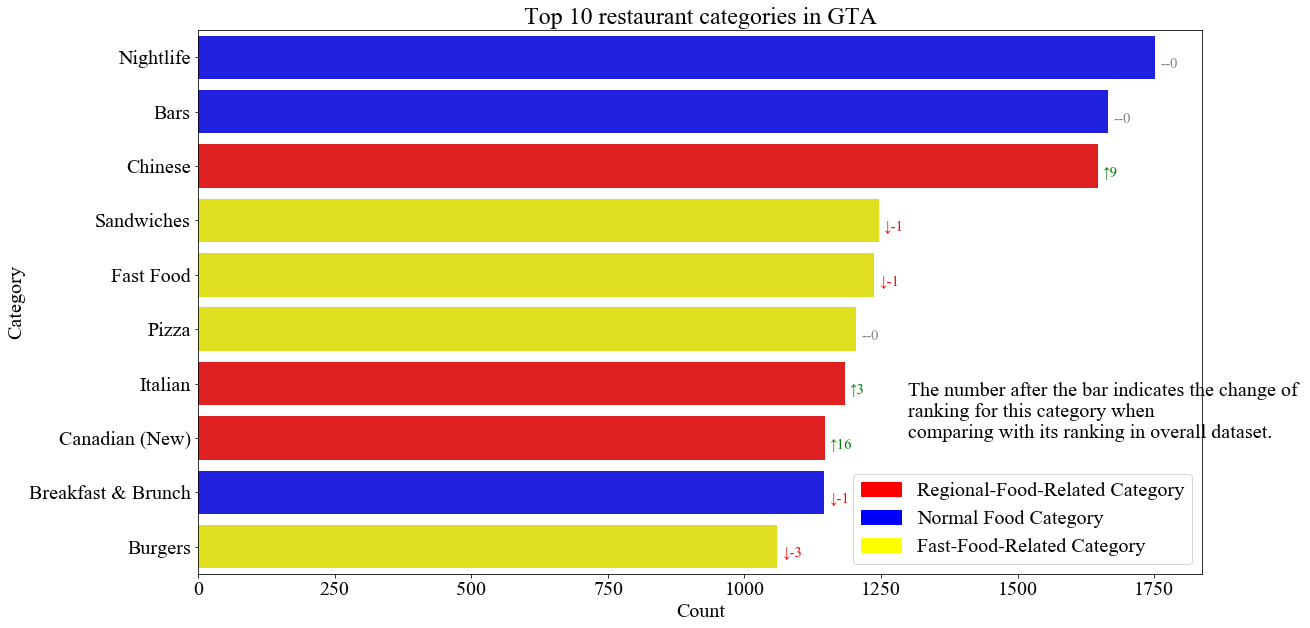

In [60]:
fig = plt.figure()
ax = fig.add_subplot()
fig.set_size_inches(18, 10)
sns.barplot(y = resuaurant_category_rank.index, x= resuaurant_category_rank.counts_x, orient = 'h', ax = ax, palette =['b','b','r','yellow','yellow','yellow','r','r','b','yellow'])
for a, r in enumerate(ax.patches):
    d = resuaurant_category_rank['Difference'][a] 
    if d > 0:
        t = "\u2191" + str(d)
        ax.text(r.get_width()+10, r.get_y()+0.6, t, size=15, color= 'green')
    elif d < 0:
        t = "\u2193" + str(d)
        ax.text(r.get_width()+10, r.get_y()+0.6, t, size=15, color= 'red')
    else:
        ax.text(r.get_width()+10, r.get_y()+0.6, "--0", size=15, color= 'grey')
ax.text(1300, 7, "The number after the bar indicates the change of \nranking for this category when \ncomparing with its ranking in overall dataset.")
red_patch = mpatches.Patch(color='red', label='Regional-Food-Related Category')
yellow_patch = mpatches.Patch(color='yellow', label='Fast-Food-Related Category')
blue_patch = mpatches.Patch(color='blue', label='Normal Food Category')
plt.legend(handles=[red_patch, blue_patch, yellow_patch])
plt.title('Top 10 restaurant categories in GTA')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()

We can observe two major characteristics from this bar plot. First, fast food related businesses take a larger proportion. This may relates to the busy lifestyle in Toronto. Second, for bars ploted in red, they are regional food, and they have the most increase in ranking among all food categories. For example Chinese(food), its rank increases dramtically to 3rd position in the GTA. It ranked 12 in the ranking of the whole data set. If we look at the demographic information in Toronto, then this result looks reasonable. The pie chart below shows the most common ancestry groups in Toronto. Here is the [access](http://worldpopulationreview.com/world-cities/toronto-population/) to this data.

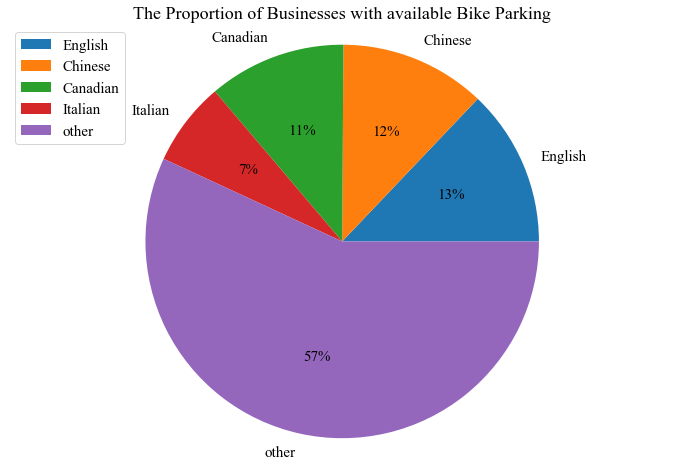

In [61]:
fig, ax = plt.subplots(figsize=(12,8))
plt.rcParams['font.family'] =  "Times New Roman"
plt.rcParams['text.color'] = 'black'
plt.rcParams['font.size']=15
labels = ['English','Chinese', 'Canadian', 'Italian', 'other']
color_palette_list = ['#009ACD', '#ADD8E6']
# Generate data for the pie chart
explode=(0.1,0)
ax.pie([0.129, 0.12, 0.113, 0.069, 0.569],  labels=labels,  autopct='%1.0f%%', 
       shadow=False, startangle=0)
ax.axis('equal')
ax.set_title("The Proportion of Businesses with available Bike Parking")
ax.legend(loc='upper left')
plt.show()

This pie chart clearly shows that Chinese ethnicity group has a high proportion of population in Toronto. Simiarly, 7% of Toronto population also has Italian background, this can explain why Chinese food and Italian food are so popular in GTA. 

### Popularity

#### Top franchises in the city
In addition to category, franchises are important for bussinss's development. Unlike normal businesses, franchises have a larger scale of branch businesses, they are more adaptable for urbanmerket. In this part, I will explore more about franchises in GTA. Notice that the way I define franchisise business in this part is: if two businesses have the exact same name in the business dataframe, I will treat them as franchises.

#### Procedure
1. Modify incorrect names of businesses into correct ones. For example, "Tim Hortons" and "Tim Horton's" are both recorded in the dataset, one of them should be modified in order to ensure the accuracy of the result.

2. Rank franchises based on
    1. Total Number of Branch Businesses
    2. Average Review Counts
    3. Average Star Evaluation

3. Check if there is any relationship between three variables above.

First, I will modify the names of businesses using fuzzwuzzy package.

In [62]:
raw_top_20_franchises = pd.DataFrame(GTA_business_df['name'].value_counts()).head(20)

In [63]:
def compare_string(lis1, lis2):
    score = []
    for x in lis1:
        temp = []
        for y in lis2:
            temp.append((x,y,fuzz.partial_ratio(x, y)))
        score.append(temp)
    return score

In [64]:
raw_top_20_franchises_score = compare_string(raw_top_20_franchises.index, GTA_business_df['name'])

In [65]:
similar_names = []
for lis in raw_top_20_franchises_score:
    temp = []
    for compare in lis:
        if compare[2] > 80 and compare[2] < 101:
            if ((compare[0], compare[1])) not in temp:
                temp.append((compare[0], compare[1]))
    similar_names.append(temp)

In [164]:
print("For instance, we may have similar names as below, and we need to standardize them:")
similar_names[-10] # pay attention, it's hard code

For instance, we may have similar names as below, and we need to standardize them


[("Tim Horton's", 'Tim Hortons'),
 ("Tim Horton's", "Tim Horton's"),
 ("Tim Horton's", 'Tim Horton Donuts'),
 ("Tim Horton's", 'Tim Horton'),
 ("Tim Horton's", 'Tim hortons')]

In [67]:
name_list = GTA_business_df['name']
name_list.replace('Starbucks Reserve', 'Starbucks', inplace = True)
name_list.replace(["Tim Horton's", "Tim Horton Donuts", "Tim Horton", "Tim Horton", "Tim hortons"], "Tim Hortons", inplace = True)
name_list.replace(["McDonalds", "McDonald", "Mcdonald's"], "McDonald's", inplace = True)
name_list.replace(["Shoppers Drug Mart Steeple Hill", "Shopper's Drug Mart", "Shoppers drug mart"], "Shoppers Drug Mart", inplace = True)
name_list.replace(["Swiss Chalet Rotisserie & Grill",  'Swiss Chalet Rotisserie and Grill/Roost'], "Pizza Pizza'", inplace = True)
name_list.replace(['Goodlife Fitness', 'GoodLife Fitness - Toronto Bell Trinity Centre', 'GoodLife Fitness - Toronto Bloor Park'], 'GoodLife Fitness', inplace = True)
name_list.replace(["Popeye's", "Popeye's Louisiana Kitchen"], "Popeyes Louisiana Kitchen", inplace = True)
name_list.replace(['The Second Cup', 'Second Cup Market Place', 'Second Cup Colossus', 'Second Cup Queensway', 'Second Cup Coffee', 
                   'Second Cup At Empress Walk'], 'Second Cup', inplace = True)
name_list.replace(['Dominos', "Domino's", 'Dominos Pizza', "Dominos' Pizza", "Dominos Pizza"], "Domino's Pizza", inplace = True)
name_list.replace(["Wild Wings", "WIld Wing", "Wild Wings Markham - Angus Glen", "Wild Wing Boxgrove"], "Wild Wing", inplace = True)
name_list.replace(["Sunset Grill Restaurant", "Sunrise Grill & Crepe"], "Sunset Grill",  inplace = True)
name_list.replace(["Wendy's Richmond Hill"], "Wendy's",  inplace = True)
name_list.replace(["Wendy's Richmond Hill"], "Wendy's",  inplace = True)
name_list.replace(['Aroma espresso bar'], 'Aroma Espresso Bar', inplace = True)
name_list.replace([i[1] for i in similar_names[-9]], 'LCBO' , inplace = True)

In [68]:
GTA_business_df['modified_name'] = list(name_list)

In [69]:
franchises_count = pd.DataFrame(GTA_business_df['modified_name'].value_counts().rename(columns = {"modified_name" : "counts"}))

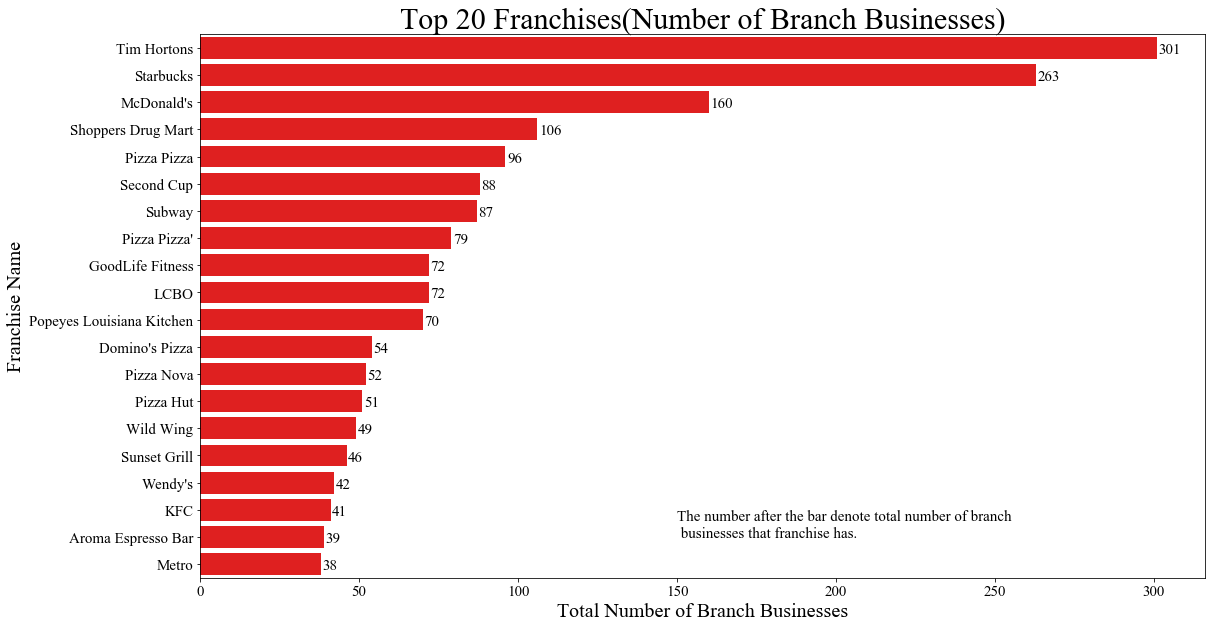

In [70]:
fig = plt.figure()
fig.set_size_inches(18, 10)
ax = fig.add_subplot()
franchises_count.columns = ['counts']
sns.barplot(y = franchises_count.head(20).index, x= franchises_count.head(20).counts, orient = 'h', ax = ax, color = 'r')
for i in range(0, 20):
    t = list(franchises_count.head(20).counts)[i]
    ax.text(t+0.5, i+0.2 , str(t),  size=15, color= 'black')
plt.title('Top 20 Franchises(Number of Branch Businesses)', size=30)
ax.text(150, 18 , 'The number after the bar denote total number of branch \n businesses that franchise has.',  size=15, color= 'black')
plt.ylabel('Franchise Name', color = 'black', size=20)
plt.xlabel('Total Number of Branch Businesses', color = 'black', size=20)
plt.show()

From the bar plot, we see Tim Hortons and Starbucks have the highest number of branch businesses in GTA. Only thees have more than 200 branch businesses in GTA. And we could also see, most of franchises in the ranking are food related. For non-food related franchises, Shoppers Drug Market is the highest among tgem, it has 106 branch businesses in total.

Now, in order to compare other attrbutes (review_counts, stars) franchines in order to to have a better understanding of this dataset.

In [71]:
franchise_name = [k for k,v in Counter(list(GTA_business_df['modified_name'])).items() if v>1]
def check_franchise(df):
    franchise = []
    franchise_name = [k for k,v in Counter(list(GTA_business_df['modified_name'])).items() if v>1]
    for i, j in df.iterrows(): 
        if j['modified_name'] in franchise_name:
            franchise.append(True)
        else:
            franchise.append(False)
    return franchise 

In [72]:
franchise = check_franchise(GTA_business_df)
GTA_business_df['franchise'] = franchise
franchise_df = GTA_business_df[GTA_business_df['franchise'] == True]

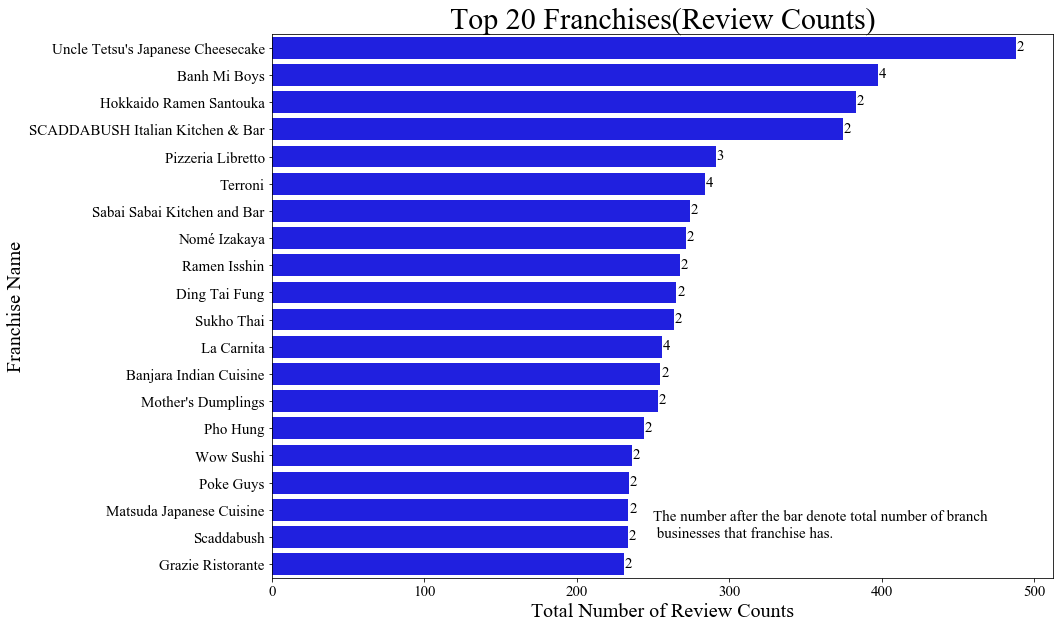

In [73]:
franchise_info =  franchise_df.groupby('modified_name').mean()
franchise_info = pd.merge(franchise_info, franchises_count, left_on = 'modified_name', right_index = True)
franchise_review = franchise_info.sort_values(by=['review_count'], ascending=False).head(20)[['review_count', 'counts']] 
fig = plt.figure()
fig.set_size_inches(14, 10)
ax = fig.add_subplot()
for i in range(0, 20):
    t = list(franchise_review.head(20).counts)[i]
    x = list(franchise_review.head(20).review_count)[i]
    ax.text(x+0.5, i+0.1 , str(t),  size=15, color= 'black')
sns.barplot(y = franchise_review.index, x= franchise_review.review_count, orient = 'h', ax = ax, color = 'blue')
ax.text(250, 18 , 'The number after the bar denote total number of branch \n businesses that franchise has.',  size=15, color= 'black')
plt.ylabel('Franchise Name', color = 'black', size=20)
plt.xlabel('Total Number of Review Counts', color = 'black', size=20)
plt.title('Top 20 Franchises(Review Counts)', size=30)
plt.show()

When we look at franchises from review counts, we may see there are many Japanese food related franchises with higher review counts. For instance Uncle Tetsu' Japanese Cheesecake, Hokkaido Ramen Santouk. On the other hand, we find most of these franchiese with high average review counts have a low number of branch businesses. In this table, the only franchise has more than 3 branches is Pizzeria Libretto.

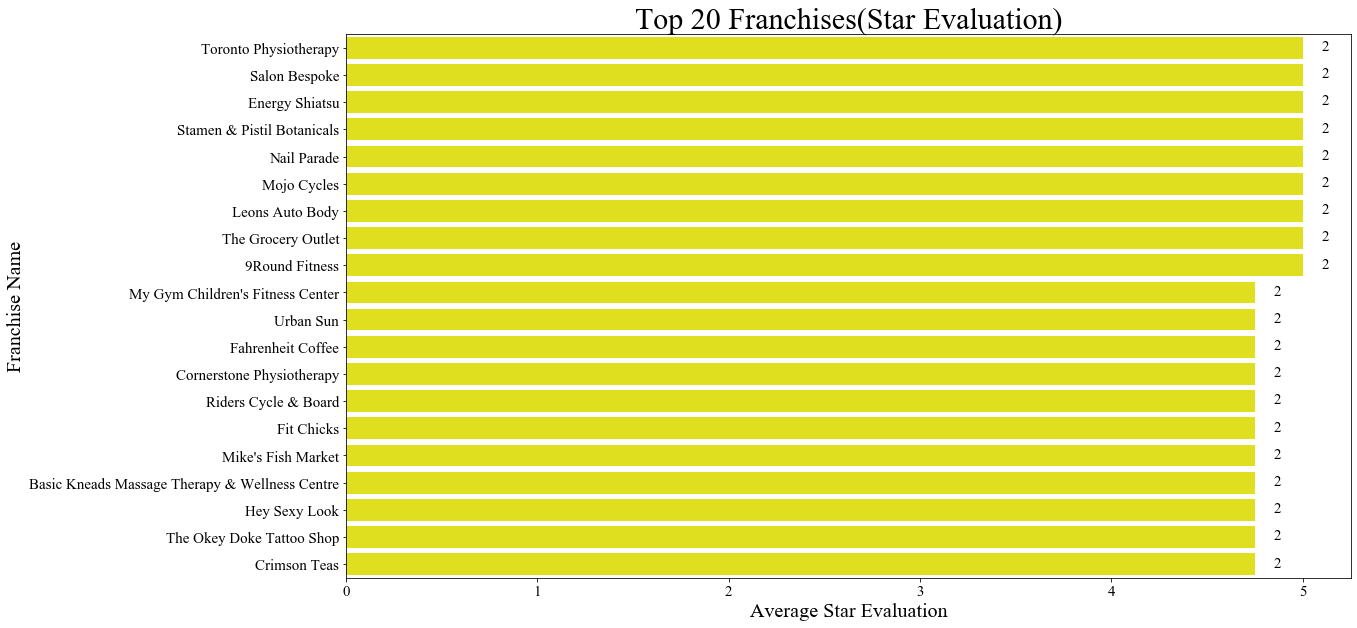

In [74]:
franchise_info =  franchise_df.groupby('modified_name').mean()
franchise_info = pd.merge(franchise_info, franchises_count, left_on = 'modified_name', right_index = True)
franchise_stars = franchise_info.sort_values(by=['stars'], ascending=False).head(20)[['stars', 'counts']] 
fig = plt.figure()
fig.set_size_inches(18, 10)
ax = fig.add_subplot()
for i in range(0, 20):
    t = list(franchise_stars.head(20).counts)[i]
    x = list(franchise_stars.head(20).stars)[i]
    ax.text(x+0.1, i+0.1 , str(t),  size=15, color= 'black')
sns.barplot(y = franchise_stars.index, x= franchise_stars.stars, orient = 'h', color = 'yellow')
plt.ylabel('Franchise Name', color = 'black', size=20)
plt.xlabel('Average Star Evaluation', color = 'black', size=20)
plt.title('Top 20 Franchises(Star Evaluation)', size=30)
plt.show()

Lastly, when we compare franchises using their average star evalution. Surprisingly, we find all of franchises with a high average star evalution has only 2 branch businesses. Now, we may think about is there a negative correlation between these variables, and I will use heatmap to visualize if there is any correlation.

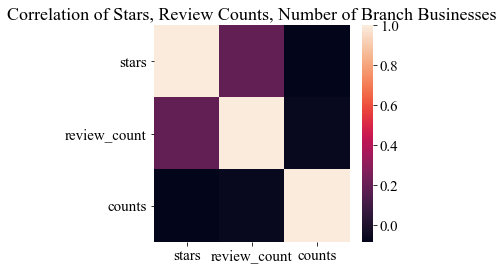

In [75]:
corr = franchise_info[['stars', 'review_count', 'counts']].corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)
plt.title("Correlation of Stars, Review Counts, Number of Branch Businesses")
plt.tight_layout()
plt.show()

From the heatmap, we did not see any evidence of correlation between number of branch businesses and average star evluation of the businesses or review counts in that category. Their correlation coefficient are too low. Therefore, based on the observations above, we may conclude for franchises with high star evaluation and review counts, the number of branch businesses for them tend to be low. This is an interesting topic to implement further investigation.

### Location and Review Counts

#### Importance of Location in Businesses
In the last part, we see there are many successful franchises in terms of their size and populairty. We may think about what are the factor demonstrate their success in businesses. Location is important because that factors greatly into how your initial customers can find you, and how often your existing customers visit. And the qustion now becomes, **is there a correlation between location and reputation of a business?** In this case, I will use revire counts to measure a business's reputation.

#### Procedure
The procedure I will use to answer this question is as following.
1. Use map to visualize the location of businesses with their review counts, to see if there any obvious pattern.
2. Group the data in terms of their location, compare their review counts in multiple ways.

In [76]:
ontario_map = geopd.read_file("ontario_administrative/ontario_administrative.shp")

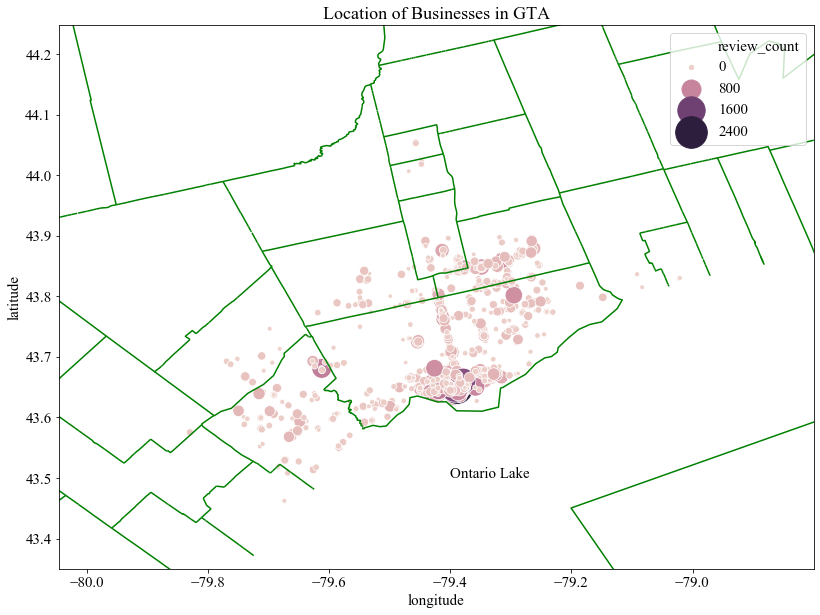

In [77]:
fig = plt.figure()
fig.set_size_inches(18, 10)
ax = fig.add_subplot()
base = sns.scatterplot(x = "longitude", y = "latitude", size = "review_count", hue = "review_count",
                       data = GTA_business_df[GTA_business_df['review_count'] > GTA_business_df['review_count'].quantile(0.95)], sizes = (20,1000), ax = ax )
ontario_map.plot(ax = ax, edgecolor = 'green')
ax.text(-79.4, 43.5 , 'Ontario Lake',  size=15, color= 'black')
plt.xlim(GTA_business_df.longitude.min()-0.1, GTA_business_df.longitude.max()+0.1)
plt.ylim(GTA_business_df.latitude.min()-0.1, GTA_business_df.latitude.max()+0.1)
plt.title('Location of Businesses in GTA')
plt.show() 

From the map, we see many businesses are concentrated around city of Toronto. For businesses outside the city, we find they spread widely. For review counts attribute, just based the map, we can not tell if there is a strong difference between businesses in different regions. Therefore, I will use other tools to see if there is any relationship between location and review counts ofbusinesses. I will group the data into two parts, one is businesses inside the city of Toronto, the other only contains businesses outside the city of Toronto, and make comparison between them.

In [78]:
Toronto_lis = []
for city in list(GTA_business_df['city'].unique()):
    if fuzz.partial_ratio(city, 'Toronto') > 80:
        Toronto_lis.append(city)

In [79]:
Toronto_lis.remove('Toronto Scarborough')
Toronto_lis.remove('Toronto-North York')

In [80]:
city_name_list = GTA_business_df['city']
city_name_list.replace(Toronto_lis, 'Toronto',  inplace = True)
GTA_business_df['modified_name_city'] = city_name_list
Toronto_business_df = GTA_business_df[GTA_business_df['modified_name_city'] == 'Toronto']
Other_business_df =  GTA_business_df[GTA_business_df['modified_name_city'] != 'Toronto']
GTA_business_df['Toronto'] = [i=='Toronto' for i in city_name_list]

From the map, we may also see businesses with review counts more than 2400 are only inside the City. So, let's consider about extreme cases where review_counts is higher than 100, to see how many of these businesses are located inside the cIty.

In [81]:
extreme_review = GTA_business_df[GTA_business_df['review_count'] > 100]

In [82]:
extreme_review_in = len(extreme_review[extreme_review['Toronto'] == True])
extreme_review_out = len(extreme_review[extreme_review['Toronto'] == False])
total_review_in = len(GTA_business_df[GTA_business_df['Toronto'] == True])
total_review_out = len(GTA_business_df[GTA_business_df['Toronto'] == False])

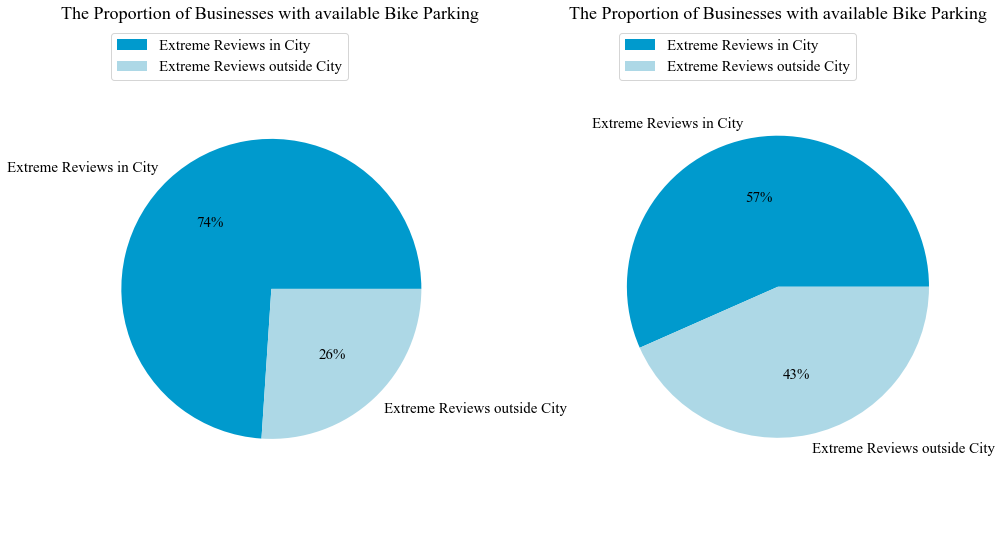

In [83]:
# Equivalent method
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(14)
axs = fig.subplots(nrows = 1, ncols = 2)
labels = ['Extreme Reviews in City', 'Extreme Reviews outside City']
color_palette_list = ['#009ACD', '#ADD8E6']
# Generate data for the pie chart
Total = bussiness_df.shape[0]
percentages = [extreme_review_in,extreme_review_out]
explode=(0.1,0)
axs.flat[0].pie(percentages,  labels=labels,  
       colors=color_palette_list, autopct='%1.0f%%', 
       shadow=False, startangle=0)
axs.flat[0].axis('equal')
axs.flat[0].set_title("The Proportion of Businesses with available Bike Parking")
axs.flat[0].legend(loc='upper left')
percentages_all = [total_review_in, total_review_out]
axs.flat[1].pie(percentages_all,  labels=labels,  
       colors=color_palette_list, autopct='%1.0f%%', 
       shadow=False, startangle=0)
axs.flat[1].axis('equal')
axs.flat[1].set_title("The Proportion of Businesses with available Bike Parking")
axs.flat[1].legend(loc='upper left')
plt.tight_layout()
plt.show()

From the piechart, we see that though the number of businesses inside the City of Toronto is just slightly higher than outside the city. However, about 75% of businesses with review counts higher than 100 are contributed by businesses inside the city. This is resaonable, because city of Toronto has a more condensed populuation and is treated like a central business distinct. Therefore, more popular businesses with high review counts may choose to locate around this region.

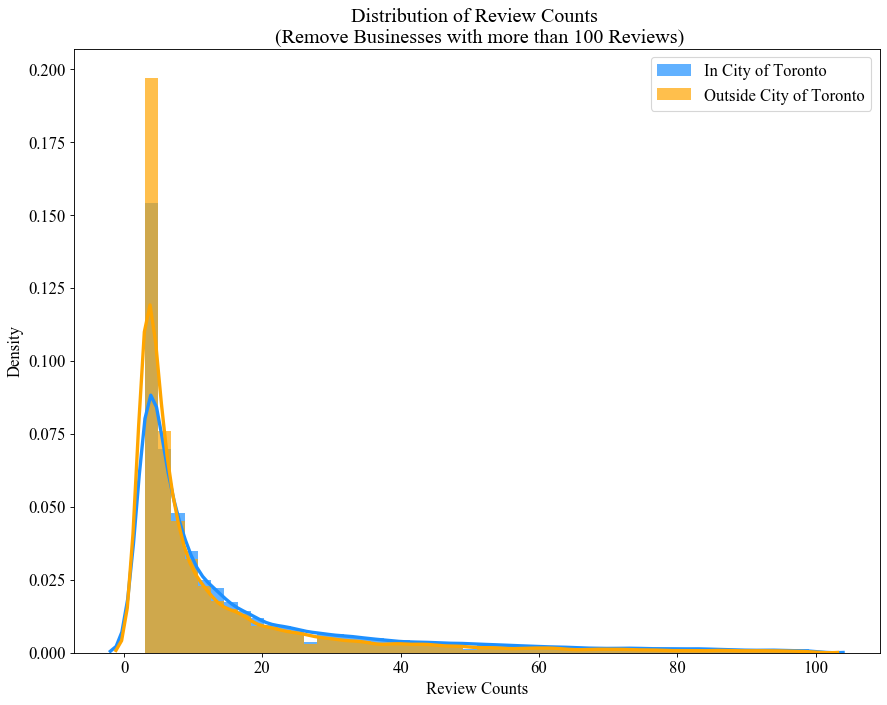

In [84]:
plt.figure(figsize=(13,10), dpi= 80)
plt.title("Distribution of Review Counts \n (Remove Businesses with more than 100 Reviews)")
plt.xlabel('Review Counts')
plt.ylabel('Density')
sns.distplot(Toronto_business_df[Toronto_business_df.review_count.astype('int') < 100].review_count, color="dodgerblue", label="In City of Toronto", hist_kws={'alpha':.7}, kde_kws={'linewidth':3})
sns.distplot(Other_business_df[Other_business_df.review_count.astype('int')  < 100].review_count, color="orange", label="Outside City of Toronto", hist_kws={'alpha':.7}, kde_kws={'linewidth':3})
plt.xlabel('Review Counts')
plt.legend()
plt.show()

Now, let's remove those businesses with review counts higher than 100, and plot the distribution for businesses with lower review counts. We find that both inside and outside of City follow a similar distribution. Most businesses have reviews less than 20. We see outside city of Toronto has a larger number of businesses with extreme low reviews.

### Example: Locations of Tim Hortons and Starbucks in GTA

#### The competition between Tim Hortons and Starbucks from location perspective
Recall the previous part, we find Tim Hortons and Starbucks are two most common franchises in GTA. And in the last part, we also demonstrates the importance of location in businesses. Now, let's combine these findings together, we may ask, What is the strategy for starbucks and tim hortons choose the locations of their businesses? How does this related to their competition?

#### Procedure
1. I will plot the distribution of two businesses on a map.
2. I will do further investigation on for every Tim Hortons, find the shortest distance between it and a Starbucks.

In [85]:
star_tim = GTA_business_df[(GTA_business_df['modified_name'] == 'Tim Hortons') | (GTA_business_df['modified_name'] == 'Starbucks')].reset_index(drop= True)

Then for every Tim Hortons, let's find a shortest starbucks nearby.

In [86]:
min_distance = []
for i in star_tim[star_tim['modified_name'] == 'Tim Hortons'].index:
    tim = GTA_business_df.iloc[i]
    temp = []
    for j in star_tim[star_tim['modified_name'] == 'Starbucks'].index:
            star = star_tim.iloc[j]
            dis = geopy.distance.distance((tim['latitude'], tim['longitude']), (star['latitude'], star['longitude'])).km
            temp.append(dis)
    x = temp.index(min(temp))
    min_distance.append(min(temp))

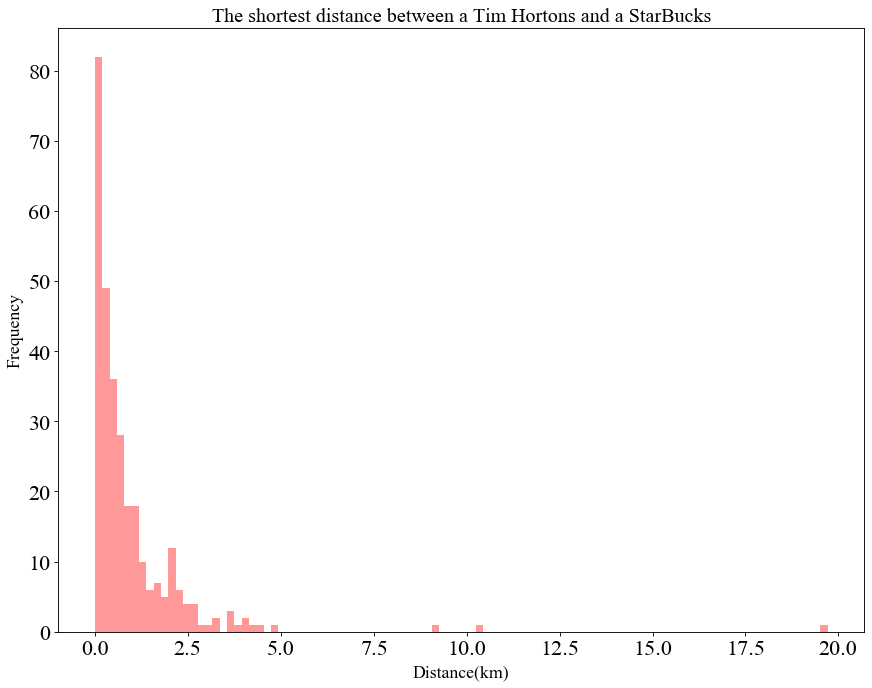

In [87]:
tim = star_tim[star_tim['modified_name'] == 'Tim Hortons']
tim['min_distance'] = min_distance
plt.figure(figsize=(13,10), dpi= 80)
plt.rcParams['font.family'] =  "Times New Roman"
plt.rcParams['text.color'] = 'black'
plt.rcParams['font.size']=20
plt.rcParams['axes.labelcolor'] = 'black'
sns.distplot(tim['min_distance'], kde=False, color='red', bins=100)
plt.title('The shortest distance between a Tim Hortons and a StarBucks', fontsize=18)
plt.xlabel('Distance(km)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.show()

From the plot, we find the shortest distances (between Starbucks) for most branches of Tim Horton's are shorter than 2.5 kilometers. If we zoom in, we find more the more number of most businesses tend to have a shorter distance since the distribution looks left skewed. Notice that there are several outliers with the shortest distances greater than 2.5 km. This is reasonable if we look at the map in the next part. The dense of businesses outside the city may not be so large, so there may be serveral cases, when we have a tim horton's, but do not have a starbucks around it.

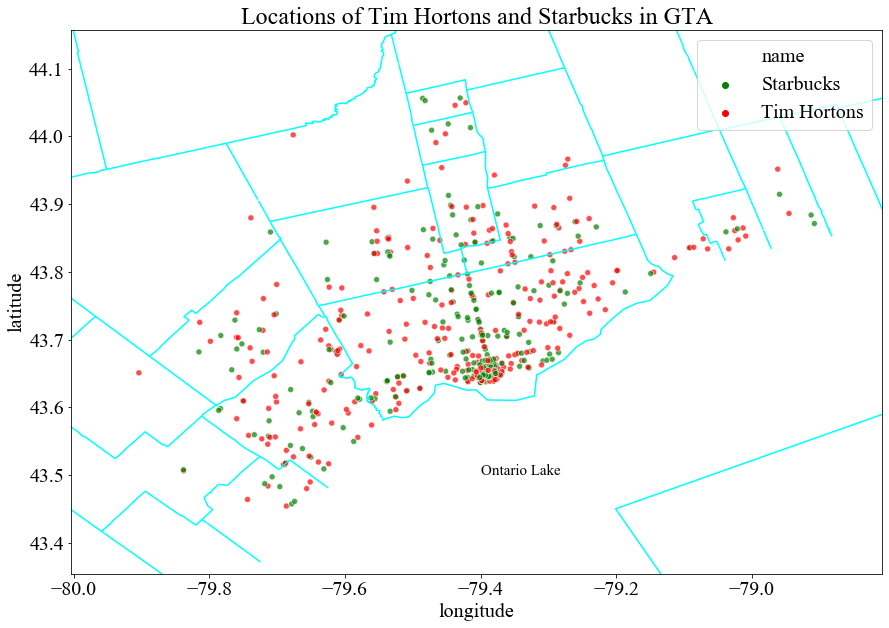

In [88]:
fig = plt.figure()
fig.set_size_inches(18, 10)
ax = fig.add_subplot()
ontario_map.plot(edgecolor= 'black', color = 'cyan', ax = ax)
sns.scatterplot(x = 'longitude', y = 'latitude', hue = 'name', data=star_tim, alpha=0.7, ax = ax, palette=["green", "red"])
plt.xlim(star_tim.longitude.min()-0.1, star_tim.longitude.max()+0.1)
plt.ylim(star_tim.latitude.min()-0.1, star_tim.latitude.max()+0.1)
ax.text(-79.4, 43.5 , 'Ontario Lake',  size=15, color= 'black')
plt.title("Locations of Tim Hortons and Starbucks in GTA")
plt.show()

From the map, we see green dots(Starbucks) and red dots(Tim Horton's) are concentrated together especially inside the city. Although as we moved away from the city, though the dense of their businesses is not as high as inside the city, we could still find that for most red dots, there is a green dot that locates very close to it. ThIs is reasonable, when one franchise set up its branch on a certain location, the selected location must be the result of careful calculation of traffic flow and careful investigation of the target market, so this outlet is the most Excellent solution. However, this location will also be a good choice for its competitor since they sell the similar products with similar targeted market.

## View the Businesses at User's Perspective

Again, Yelp is a tool to shorten **the information gap** between two sides of transaction, on the one side, are the **businesses** on the other side, are the **customers**. In the previous part, we dicusses about businesses in depth. In this part, we will use our findings in the previous part to invesitigate more characteristics of users and reviews in the dataset. I will first load this huge dataset.

In [89]:
review = pd.read_json("yelp_dataset/review.json", lines = True, chunksize = 500000)
review_subset = next(review)
while True: 
    try:
        review_subset = pd.concat([review_subset, next(review)])
    except StopIteration:
        print('Finish Loading Review dataset')
        break
    except MemoryError:
        print('Memory Error')
        break
review = review_subset

Finish Loading Review dataset


In [90]:
user = pd.read_json("yelp_dataset/user.json", lines = True, chunksize = 500000)
user_subset = next(user)
while True: 
    try:
        user_subset = pd.concat([user_subset, next(user)])
    except StopIteration:
        print('Finish Loading User dataset')
        break
    except MemoryError:
        print('Memory Error')
        break
user = user_subset

Finish Loading User dataset


### A small group of users that is responsible for most reviews
In the previous part, we see there are some businesses contribute more to the market, while some are not so significant. Similarly, a small group of users may contribute most reviews. In this part, i will invesitigate if there is a small group of users that is responsible for most reviews. In most cases, the more reviews a user wrote, the more reliable is the user. If there is a group responsible for most reviews, we can help the Yelp **develop an algorithm** to filter meaningful and reliable reviews.

#### Attributes of a User
Since we want to form a group users with high **review_counts**, the characteristics of this group must be defined by other attributes in the user dataset. By overview of the data, we see **elite**, **fans**, **compliment_total** may relate to the review counts by their definition.
By definition, a user may become an elite if he/she provides thoughtful reviews, awesome photos, sending compliments, up-voting reviews. I look deeper into the relationship between these attributes and review counts.

#### Procedure
1. Group users into elite users and other users. Find the total reviews they contribute to the dataset in each group.
2. Group users into users who have more than 3 fans and users who have less than 3 fans (inclusive). Find the total reviews they contribute to the dataset in each group.
3. Find the overlap between two groups.

In [91]:
elite_user = user[user['elite'] != ''] 

In [92]:
total_review_elite_ratio = sum(elite_user.review_count) / sum(user.review_count)

In [93]:
total_elite_ratio = elite_user.shape[0]/user.shape[0]

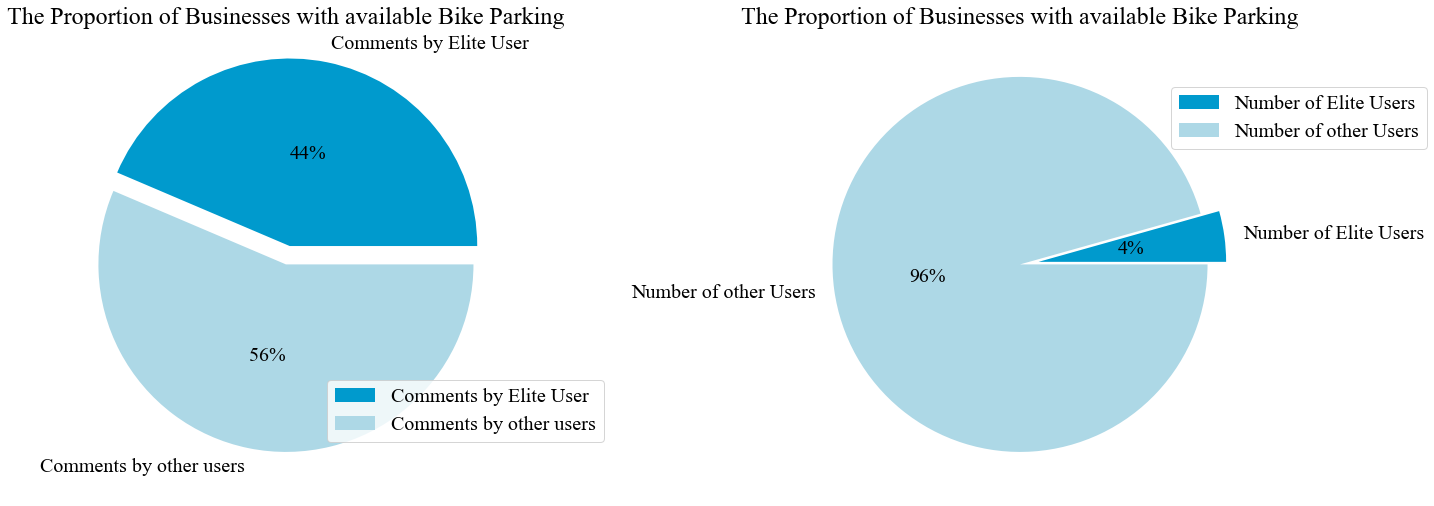

In [94]:
fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(20)
axs = fig.subplots(nrows = 1, ncols = 2)

axs.flat[0].pie([total_review_elite_ratio, 1 -total_review_elite_ratio],  labels=['Comments by Elite User', 
         'Comments by other users'],  
       colors=color_palette_list, autopct='%1.0f%%', 
       shadow=False, startangle=0,pctdistance=0.5,labeldistance=1.1,explode=explode)

axs.flat[0].set_title("The Proportion of Businesses with available Bike Parking")
axs.flat[0].legend(loc = 4,  bbox_to_anchor=(1.2, 0.1))

axs.flat[1].pie([total_elite_ratio, 1- total_elite_ratio], explode=explode, labels= ['Number of Elite Users', 
         'Number of other Users'],  
       colors=color_palette_list[0:2], autopct='%1.0f%%', 
       shadow=False, startangle=0,   
       pctdistance=0.5)
axs.flat[1].set_title("The Proportion of Businesses with available Bike Parking")

axs.flat[1].legend(loc = 2, bbox_to_anchor=(0.8, 0.9))
plt.tight_layout()
plt.show()

From the pie chart, we see that only 4 percent of users are elite. Howevr, they contribute more than 40% of comments. Therefore, elite users is a small group that contributes to many reviews in this dataset. This is reasonable, as we discusses above, users can become elite only if they provide high quaility reviews with many other users' complementary reflections. So an elite user should have written many reviews.

In [95]:
have_fans = user[user['fans'] > 3]
total_review_have_fans_ratio = sum(have_fans.review_count) / sum(user.review_count)
total_have_fans_ratio = have_fans.shape[0]/user.shape[0]

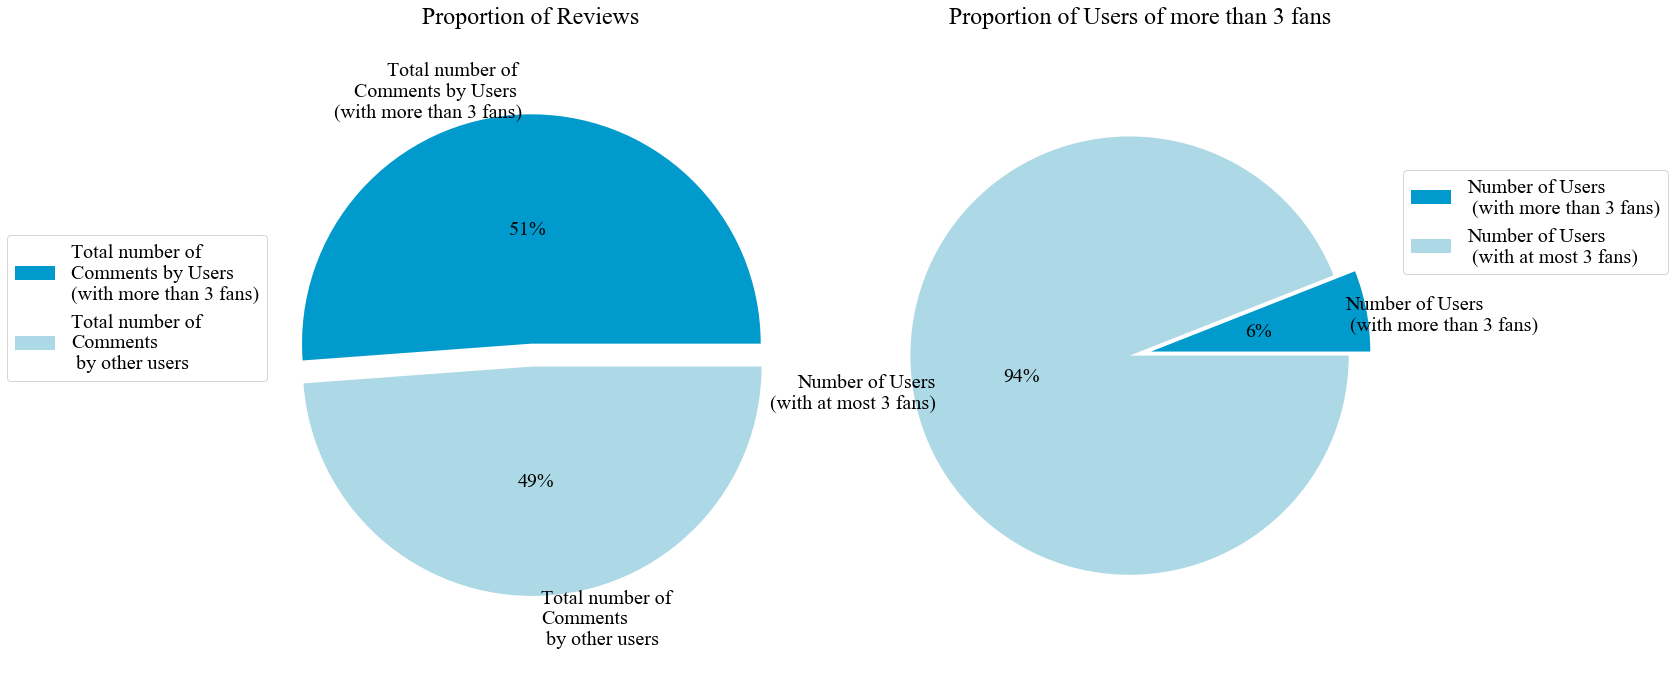

In [148]:
fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(20)
axs = fig.subplots(nrows = 1, ncols = 2)
percentages = [total_review_have_fans_ratio, 1 -total_review_have_fans_ratio]
explode=(0.1,0)
axs.flat[0].pie(percentages, explode=explode, labels= ['Total number of \nComments by Users \n(with more than 3 fans)', 
         'Total number of \nComments\n by other users'],  
       colors=color_palette_list[0:2], autopct='%1.0f%%', 
       shadow=False, startangle=0,   
       pctdistance=0.5,labeldistance=1.1)
axs.flat[0].axis('equal')
axs.flat[0].set_title("")
axs.flat[0].legend(bbox_to_anchor=(0, 0.7))
axs.flat[0].set_title("Proportion of Reviews")

total_review_have_fans_ratio = sum(have_fans.review_count) / sum(user.review_count)
total_have_fans_ratio = have_fans.shape[0]/user.shape[0]
total_have_fans_ratio, 1 -total_have_fans_ratio
axs.flat[1].pie([total_have_fans_ratio, 1 -total_have_fans_ratio], explode=explode, labels=['Number of Users\n (with more than 3 fans)',  
                                                                                            'Number of Users\n (with at most 3 fans)'],
       colors=color_palette_list[0:2], autopct='%1.0f%%', 
       shadow=False, startangle=0,   
       pctdistance=0.5,labeldistance=0.9)
axs.flat[1].axis('equal')
axs.flat[1].legend(bbox_to_anchor=(1, 0.8))
axs.flat[1].set_title("Proportion of Users of more than 3 fans")
plt.show()

From the pie chart, we see although there are only 6% of users have more than 3 fans, but they contribute to more than half of the reviews in the dataset. Therefore, we may conclude this is also a small group of users contribute to most reviews in the dataset. This is also reasonable, the most common way for users to attract other users in Yelp is through writing reviews, for users who wrote reviews more frequent than other users, they should have more fans.

In [97]:
total_review_have_fans_ratio = sum(have_fans.review_count) / sum(user.review_count)
total_have_fans_ratio = have_fans.shape[0]/user.shape[0]
elite_have_fans_ratio = elite_user[elite_user['fans']>3].shape[0]/elite_user.shape[0]

So, the next question comes to are users with more fans actually overlap with elite users. In another word, are elite users and users with more than 3 fans actually the same group of people.

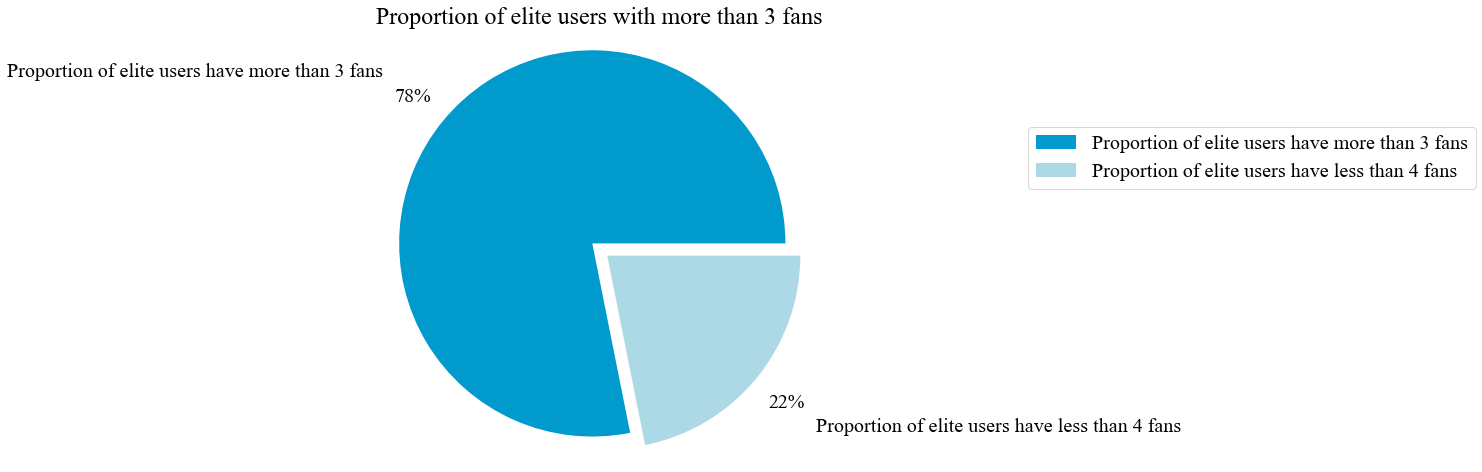

In [143]:
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(15)
labels = ['Total number of Comments by Elite User', 
         'Total number of Comments for all users']
color_palette_list = ['#009ACD', '#ADD8E6', '#63D1F4', '#0EBFE9',   
                      '#C1F0F6', '#0099CC']
percentages = [elite_have_fans_ratio, 1 -elite_have_fans_ratio]
explode=(0.1,0)
ax.pie(percentages, explode=explode, labels=['Proportion of elite users have more than 3 fans', 'Proportion of elite users have less than 4 fans'],  
       colors=color_palette_list[0:2], autopct='%1.0f%%', 
       shadow=False, startangle=0,   
       pctdistance=1.2,labeldistance=1.4)
ax.axis('equal')
ax.set_title("Proportion of elite users with more than 3 fans")
ax.legend(bbox_to_anchor=(1, 0.8))
plt.show()

From the pie chart, we see that about 80% of elite users have more than 3 fans.

### View the competition in User's perspective

#### A Competition Between Tim Horton's and Starbucks
Recall previous part, we know Tim Horton's and Starbucks are two most common franchises in GTA in terms of their number of branch businesses, **quantity**. Since Tim Horton's and Starbucks provide similar services and products, they are the major **competitors** in this region. However, we know the quantity is just one perspective of businesses, the **quality** of service and product is also essential for the development of businesses. I will dig deeper into their competition in terms of their service quality in this part. And then give two companies some suggestions for their future development.

#### Reviews in the Dataset
Which one is better in Toronto citiezen's view? for How do people actually think of them? These are controversial questions.
To know about the quality of their services and products, we need to start with their customers. The Yelp dataset provides us with a large number of customers' reviews. We can not read through each review one by one since there about thousands of them. However, there are still two ways for us to interpret these reviews in an effcient way.

1. **The (adjective）keywords in reviews.** 

2. **The sentiment scores in reviews.**

#### The Procedure
Based on above, the procedure I use to answer this question is 

1. **Group the data**. Select the dataframe of reviews about GTA's Tim Horton's and Starbucks.
2. **Compare keywords**. Extract the keyword in grouped reviews, compare and contrast them.
3. **Compare sentiment scores**. Extract the sentiment scores in grouped reviews, compare and contrast them.
3. **Compare reviews of common users**. Find characteristcs of reviews written by users who reviewed both establishments.

In [99]:
merged_timstar_review = pd.merge(star_tim, review, on='business_id')

In [100]:
tim_review = merged_timstar_review[(merged_timstar_review['name'] == 'Tim Hortons')]
star_review = merged_timstar_review[(merged_timstar_review['name'] == 'Starbucks')]

From previous research, we see review in Yelp is a very powerful tool to determine. However, its limitation is also obvious, accoring to  

In [101]:
def get_key_word_dict(df):
    dic = {}
    for s in df.text:
        s = re.sub(r'[^\w\s]','',s)
        s = s.lower().split()
        for w in s:
            if w not in dic:
                dic[w] = 1
            else:
                dic[w] = dic[w] + 1
    return dic

In [102]:
def add_word_type(df):
    lis = []
    for w in df.word:
        if len(wn.synsets(w)) == 0:
            lis.append(np.nan)
        else:
            lis.append(wn.synsets(w)[0].pos())
    df['type'] = lis   

In [103]:
tim_word_count = pd.DataFrame.from_dict(get_key_word_dict(tim_review), orient='index')
tim_word_count.columns = ['count']
tim_word_count.reset_index(inplace = True) 
tim_word_count.columns = ['word','count']
add_word_type(tim_word_count)
grouped_tim_word_count = tim_word_count.groupby('type')
star_word_count = pd.DataFrame.from_dict(get_key_word_dict(star_review), orient='index')
star_word_count.columns = ['count']
star_word_count.reset_index(inplace = True) 
star_word_count.columns = ['word','count']
add_word_type(star_word_count)
grouped_star_word_count = star_word_count.groupby('type')

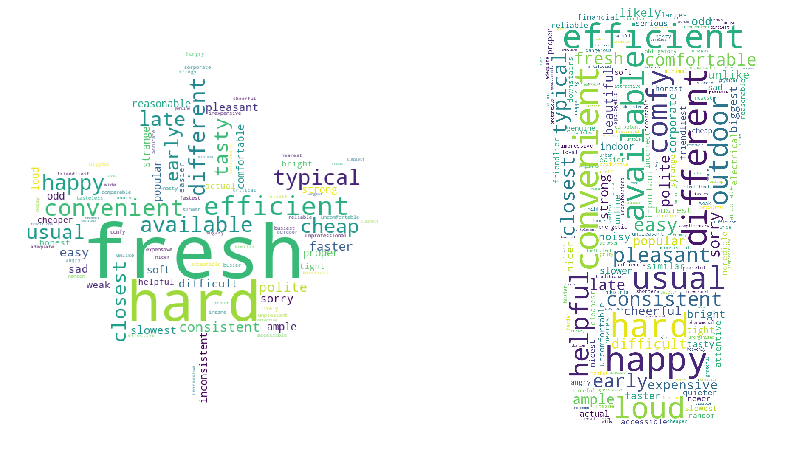

In [104]:
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(15)
axs = fig.subplots(nrows = 1, ncols = 2)
tim_text = ''
for index, row in grouped_tim_word_count.get_group('a').iterrows():
    i = 0 
    while i < row['count']:
        tim_text = tim_text + " " + row['word'] 
        i = i + 1
stopwords = set(STOPWORDS)
stopwords.update(['many', 'sure', 'many', 'able','big', 'new', 'hot'])
mask = np.array(Image.open("maple.jpg"))
wordcloud = WordCloud(width = 1000, height = 1000, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 5, collocations = False, mask =mask).generate(tim_text)
axs.flat[0].imshow(wordcloud) 
axs.flat[0].axis("off") 
star_text = ''
for index, row in grouped_star_word_count.get_group('a').iterrows():
    i = 0 
    while i < row['count']:
        star_text = star_text + " " + row['word'] 
        i = i + 1
mask = np.array(Image.open("starbucks.jpg"))
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 5, collocations = False, mask =mask).generate(star_text)
axs.flat[1].imshow(wordcloud) 
axs.flat[1].axis("off")  
plt.show() 

The left maple leaf word cloud corresponds to keywords appear in reviews for Tim Horton's. 
The right coffee cup word cloud corresponds to keywords appear in reviews for Starbucks.
The size of the words corresponds to the frequency of the words appeared in the review.
Obvisouly, we see a positive words "efficient", "fresh", "convenient" occur in both wordclouds, this demonstrates the common characteristics of two franchises in user's view.
On the other hand, we find some negative words, such as 'hard', 'load', 'late' appear in both word clouds.  The similariy of keywords is high between two wordclouds. This is reasonable, because both businesses provide similar services.

In [105]:
tim_star_intersection = pd.concat([tim_review,star_review])
tim_star_intersection = tim_star_intersection[tim_star_intersection.duplicated('user_id', keep=False)]

In [106]:
def read_comments(df):
    neg = []
    neu =[]
    pos = []
    compound = []
    sia = SIA()
    for i, j in df.iterrows(): 
        temp = sia.polarity_scores(j['text'])
        neg.append(temp['neg'])
        neu.append(temp['neu'])
        pos.append(temp['pos'])
        compound.append(temp['compound'])
    df['neg'] = neg
    df['neu'] = neu
    df['pos'] = pos
    df['compound']  = compound

In [107]:
def word_count(df):
    count = []
    for i, j in df.iterrows(): 
        temp = sum([w.strip(string.punctuation).isalpha() for w in j['text'].split()])
        count.append(temp)
    df['word_count'] = count

In [108]:
read_comments(merged_timstar_review)
word_count(merged_timstar_review)

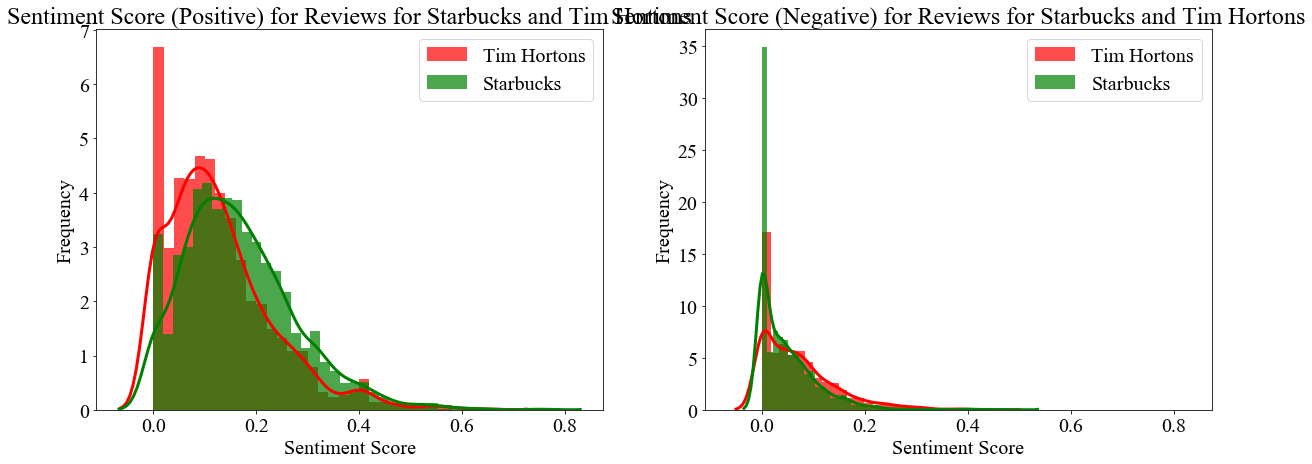

In [109]:
f, axes = plt.subplots(1, 2, figsize=(20, 7), sharex=True)
sns.distplot(merged_timstar_review[merged_timstar_review['name'] == 'Tim Hortons']['pos'], color="red", label="Tim Hortons", hist_kws={'alpha':.7}, kde_kws={'linewidth':3}, ax = axes[0])
axes[0].set_title('Sentiment Score (Positive) for Reviews for Starbucks and Tim Hortons')
axes[0].set_ylabel('Frequency')
sns.distplot(merged_timstar_review[merged_timstar_review['name'] == 'Starbucks']['pos'], color="green", label="Starbucks", hist_kws={'alpha':.7}, kde_kws={'linewidth':3}, ax = axes[0])
sns.distplot(merged_timstar_review[merged_timstar_review['name'] == 'Tim Hortons']['neg'], color="red", label="Tim Hortons", hist_kws={'alpha':.7}, kde_kws={'linewidth':3}, ax = axes[1])
sns.distplot(merged_timstar_review[merged_timstar_review['name'] == 'Starbucks']['neg'], color="green", label="Starbucks", hist_kws={'alpha':.7}, kde_kws={'linewidth':3}, ax = axes[1])
axes[1].set_title('Sentiment Score (Negative) for Reviews for Starbucks and Tim Hortons')
axes[1].set_ylabel('Frequency')
axes[1].set_xlabel('Sentiment Score')
axes[0].set_xlabel('Sentiment Score')
axes[1].legend()
axes[0].legend()
plt.show()

From the two distribution plots above, we find that the frequency of positive reviews for Tim Horton is much lower than Starbucks. The peak of positive sentiment score for Tim Hortons is zero. For high positive sentiment score, Starbucks always has a higher frequency than Tim Hortons. On the other hand, in the negative sentiment score distribution, the peak of Starbucks is 0. This indicates that Starbucks always left costumers with a more positive impression. For high negative sentiment score, Starbucks always has a lower frequency than Tim Hortons.

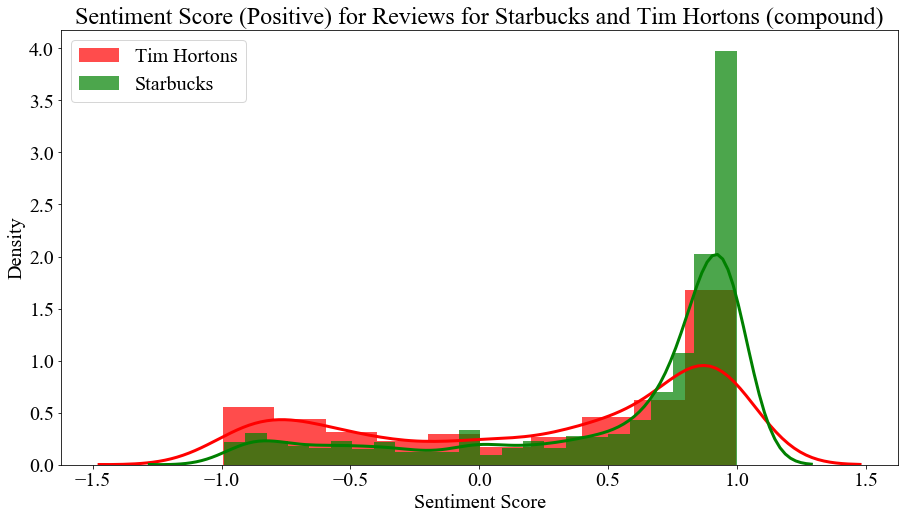

In [110]:
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(15)
sns.distplot(merged_timstar_review[merged_timstar_review['name'] == 'Tim Hortons']['compound'], color= 'red', label="Tim Hortons", hist_kws={'alpha':.7}, kde_kws={'linewidth':3})
sns.distplot(merged_timstar_review[merged_timstar_review['name'] == 'Starbucks']['compound'], color="green", label="Starbucks", hist_kws={'alpha':.7}, kde_kws={'linewidth':3})
plt.title('Sentiment Score (Positive) for Reviews for Starbucks and Tim Hortons (compound)')
plt.ylabel('Density')
plt.xlabel('Sentiment Score')
plt.legend()
plt.show()

Now, lets's look at the compund distribution. We see most Starbucks reviews are generally more positive than Tim Hortons. We can combine this with the result of average star evluation for two businesses in GTA. For Starbucks, it has a higher average stars (3.4 stars) than Tim Hortons (2.6 stars). Both star evulation and review emotion demonstrate Starbucks has a better impression for customers than Tim Hortons.

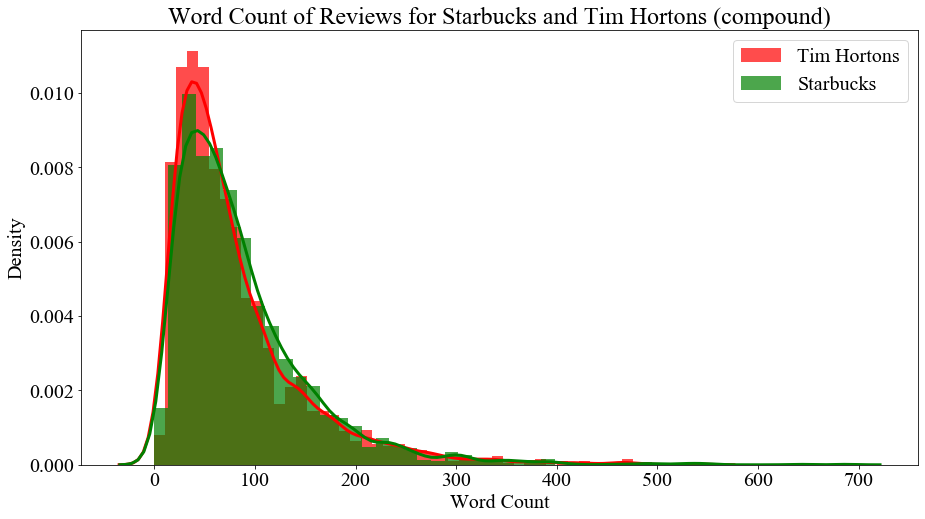

In [111]:
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(15)
sns.distplot(merged_timstar_review[merged_timstar_review['name'] == 'Tim Hortons']['word_count'], color="red", label="Tim Hortons", hist_kws={'alpha':.7}, kde_kws={'linewidth':3})
sns.distplot(merged_timstar_review[merged_timstar_review['name'] == 'Starbucks']['word_count'], color="green", label="Starbucks", hist_kws={'alpha':.7}, kde_kws={'linewidth':3})
plt.title('Word Count of Reviews for Starbucks and Tim Hortons (compound)')
plt.ylabel('Density')
plt.xlabel('Word Count')
plt.legend()
plt.show()

Another aspect to look at is word count of reviews for two businesses. We find that they follow similar distribution. There is not a huge difference between review lengths for two businesses. 

It is important for us to take a look at users who have been to both restaurants to give us a fair jusgement. Among the intersection of reviewer of tim and starbucks, we first take a look at the stars they give, and then look at the intersection of the comments they give.

In [112]:
inter_tim_word_count = pd.DataFrame.from_dict(get_key_word_dict(tim_star_intersection[tim_star_intersection['name'] == 'Tim Hortons']), orient='index')
inter_tim_word_count.columns = ['count']
inter_tim_word_count.reset_index(inplace = True) 
inter_tim_word_count.columns = ['word','count']
add_word_type(inter_tim_word_count)
grouped_inter_tim_word_count = inter_tim_word_count.groupby('type')

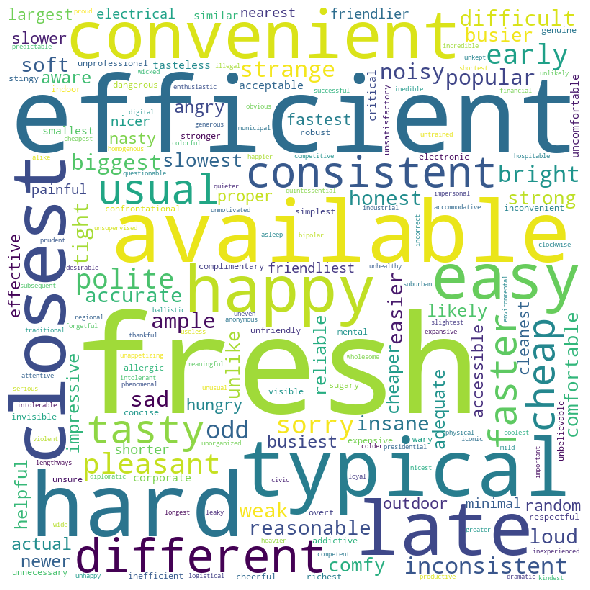

In [113]:
inter_tim_text = ''
for index, row in grouped_inter_tim_word_count.get_group('a').iterrows():
    i = 0 
    while i < row['count']:
        inter_tim_text = inter_tim_text + " " + row['word'] 
        i = i + 1
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 5, collocations = False).generate(inter_tim_text)
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

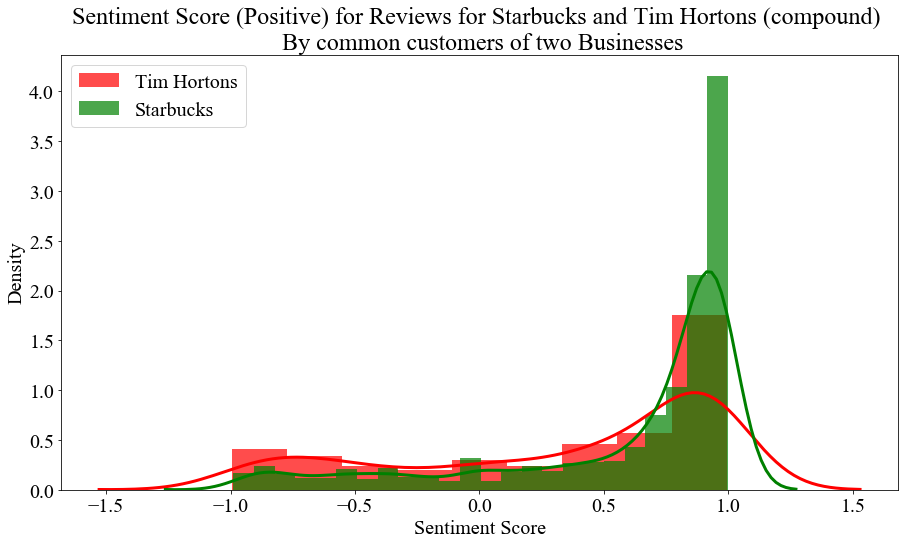

In [115]:
read_comments(tim_star_intersection)
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(15)
sns.distplot(tim_star_intersection[tim_star_intersection['name'] == 'Tim Hortons']['compound'], color= 'red', label="Tim Hortons", hist_kws={'alpha':.7}, kde_kws={'linewidth':3})
sns.distplot(tim_star_intersection[tim_star_intersection['name'] == 'Starbucks']['compound'], color="green", label="Starbucks", hist_kws={'alpha':.7}, kde_kws={'linewidth':3})
plt.title("Sentiment Score (Positive) for Reviews for Starbucks and Tim Hortons (compound) \n By common customers of two Businesses")
plt.ylabel('Density')
plt.xlabel('Sentiment Score')
plt.legend()
plt.show()

We see for users who have been to both Tim Hortons and Starbucks, the sentiment score of Starbucks is still generally higher than Tim Hortons. So it is fair to judge Starbucks provide better service and products in users' views. 

### A Conclusion for this competition 
Combining the results of previous part. We may conclude that the competition between Starbucks and Tim Hortons is fierce. They always locate around each other in GTA. Though Starbucks falls behind int terms of its business quantity (the number of branch businesses), it has a better impression than Tim Hortons in customer's view. Therefore, Tim Hortons may need to improve its service quality to keep its leading position in terms of business quantity.

### Paid Reviewers
I break this part into several parts.
#### How do fake reviews affect us?
As [Yelp](https://www.yelp-support.com/article/Can-I-report-a-business-that-is-trying-to-pay-people-to-write-positive-reviews?l=en_US) company mentioned in their website, paid reviews are not allowed. However, according to [Fortune](https://fortune.com/2013/09/26/yelps-fake-review-problem/), this problem currently still exists, and may have bad effects on several aspects.
1. **Damage the reputation of the Yelp evaluation system.** Yelp is a review-based company, without reliability of reviews, it will definitely lose its attractions to customers.
2. **Mislead Users**. According to Yelp’s VP of corporate communications Vince Sollitto, fake reviews will "mislead consumers, it violates our guidelines, but more importantly it violates the law.”
3. **Damage the fairness of the market.** If a single businesses gain more profit through buying fake reviews, more companies will pay attention to instead of providing products and services itself. This may lead to a vicious competition in the market. Yelp, as a Influential company, should be responsible for its inflence on the market, lead the market in a healthy way.

#### Limitation and Ideal Approach

There are two aspects we can look at when we detect paid reviews, they are characteristics of **reviews** themseleves and then combine it with characteristics of **users**. Unfortunately, we do not have a truthfulness of review in the given dataset. I try to look for sample fake review dataset online, but they are neither for yelp nor for other businesses reviews. This is the biggest **limitation** for this question. If I have a sample of large number fake reviews, I will construct a decision tree. This **decision tree** will that takes the review text, some other characteristics of reviews and user information as the input, and whether a given review is fake. Also, by detecting reviews of a given user, we can also predict whether a user is a paid writer.

#### What do Fake Reviews may look like?

Even if we do not have examples of fake reviews, we can still predict characteristics of fake reviews based on our life experience and results of other studies.

1. **Automatic-Generated Fake Reviews**. These reviews are low quality, but the 'writer' of this review may write these reviews very frequently. So, below is a predicted standard for Automatic-Generated Fake Reviews.
    1. Review text has length lower than 20 words. (Review Aspect)
    2. The review is not useful, funny and cool (these attributes are all zero). (Review Aspect)
    3. The writer of these reviews does noy have fans or any compliments. (User Aspect)
    4. The user only gives 5 stars evaluation, and the number of reviews he/she wrote should be more than 10. (User Aspect)
    5. It would be better if we have **IP addresses** of these reviewers, since a user may use different accounts with the same IP address.
    
2. **Hand-Written Fake Reviews** These reviews have higher quality, and the 'writer' of these reviews may write these reviews similarly as normal users. This makes this kind of fake reviews harder to distinguish, so that we have to look into the contents of reviews. Below is a predicted standard for Hand-Written Fake Reviews.
    1. Review text has length between 10-50 words. (Review Aspect)
    2. The review may be marked as at most one useful, funny and cool. (Review Aspect)
    2. A lot of superlatives and not much description. Phrases like “a must-read” and “life-changing” are giveaways. References to other people such as “my family” or “my husband. (Review Aspect)
    3. Reviews that sound like a marketing brochure from the company or use the full official name of the product. (Review Aspect)
    3. The user only gives 5 stars evaluation, and the number of reviews he/she wrote should be more than 20. (User Aspect)
    4. The sentiment of language in reviews is overall too positive. (User Aspect)
    5. Self-Contradiction. For example, a reviewer may have a 'husband' in one review, while have a 'wife' in another review. (User Aspect)

Notice that the second kind of fake reviews may require some advanced tool including Lexical features such as word n-grams, part-of-speech n-grams, and other lexical attributes, semantic inconsistency checking. I will not cover investigation of Hand-Written Fake Reviews in this part, and this can be improved in the future. 



In [155]:
suspect_users = user[(user['average_stars'] ==  5) 
                & (user['review_count'] > 10) 
                &((user['useful'] + user['funny'] + user['cool']) < 1)
                & (user['friends'] == 'None') 
                & (user['fans'] == 0)
               ]

In [156]:
final  = pd.merge(suspect_users, review, on = 'user_id')[['user_id', 'text']]
fake = final[final.text.apply(lambda x: len(x.split(" ")) < 20)]

#### Result
According to our **Automatic-Generated Fake Reviews** standard, in this data set, of reviews are considered as possible fake reviews. And are suspected paid reviewers. As we discussed above, it would be better if we have IP address of those reviewers. There are about 70 suspected paid reviewers in the dataset. I pick some reviews that looked fake from those reviewers: 

- "yeah buddy' dam good' wish i had some right now" -- User ID: jmO2OUxTaIV_rLRjRXSxuA
- "This is a blast from the past! Good quality food and service. Local owners, local employees great value" (Repeted Reviews) -- User ID: hU62m1mokKTcEm4aNrxOiQ
- "Wow, just wow I can't tell you how good this place is, while in Montreal this is a must." -- User ID: Zduokg2jobtiohiOpND6nw

## Conclusion
In this report, we go through the **Yelp business dataset in an overall perspective** (Part I), and then we zoom into **businesses in GTA** (Part II), and finally look at the businesses from **users' aspect** (Part III).

In the first part, we find that most businesses's **locations** in this dataset are concentrated in some regions in the United States and Canada. And through the investigation on the **category** attribute, we find restaurant and its subcategories are the most frequent businesses in the dataset. Also, we recommend to use the **hierarchical organization** to record category information in the future. Next, we discuss the convenience of establishments in terms of their bike parking availability. We find that some categories may have a higher proportion of businesses with bike parking available because of **the cultural background**. And we also find bike parking availability may have a positive **assoication** with the evaluation of the businesses. In fact, more yelp reviews may also lead to a higher rating for a business (except 5 star evalution).

In the second part, we do a **comparison** between "the whole and the part" (GTA vs. Whole) in terms of the most frequent category. We find that in GTA, although most popular categories in the whole dataset still remain their popularity in GTA, there are some special categories that are only popular in GTA. This may be due to Toronto's diverse **cultural background**. Then, we discusses top franchises in the city in terms of **the number, the average count and star evluation** of branch businesses of franchises in the city. We find some franchises may have a large number of branch businesses, but do not have a higher reputation among franchises. Next, we group the data into businesses inside the city of Toronto and outside to invesigate the relationship between **location** of business and their reviews. We find that most businesses with high **reviews** are concentrated in City of Toronto. Lastly, we choose two most common businesses in GTA, Tim Hortons and Starbucks to compare their location pattern. We find that most for every Tim Hortons, there is always a Starbucks close it, which shows the fierce competition between them.

In the last part, we focus on user's opinion on businesses. We find that there is a group of users contribute to most reviews in the dataset. Some evidence show that many of them are elite users of Yelp. Then, we continue talking about the **competition** between Tim Hortons and Starbucks in terms of the quality of their product and service. We find that though Tim Hortons kept the lead of the **quantity** of businesses, it fell behind in the **quality** of businesses. Lastly, we do a further investigation on **detection of 'paid review'**. Due to the limitation of the dataset, we cannot form an accurate procedure to detect the truthfulness of the review. 

Again, throughout the whole report, we have better understandings of following aspects:
1. Characteristics of all Businesses in the dataset, Including their popularity, location, etc.
2. Characteristics of Businesses in the dataset in a particular region, compare it with the whole data set. Since we are in Toronto, so we will do investigation on the GTA.
3. Characteristics of reviews in the dataset, and make connection with users and reviews.

The result of this report may also help:
1. Improvement of Yelp service.
2. Development of Local Businesses.
3. Prediction of future businesses trend.

## Limitation

There are some limitations of this report that may be improved in the future.

1. Yelp data set may not represent the true businesses condition. Not everyone uses Yelp to evaluate local businesses, this data set may only reflect a proportion of people's opinion on businesses. So when we do analysis and want to conclude public opinion's on a business, we need to pay attention to this limitation.

2. This data set is a subset. Based on our finding in part I, we know this data set only contains businesses in a small proportion in cities. Therefore, we cannot conclude anything about businesses 'in the United States' or even larger scale. Instead, we can only conclude what is inside the data set.

3. Reliability of business reviews. Everything we did in the part 3 is based on the reviews in the dataset. However, as we know, the reviews have problems with their reliability due to fake review issue. 

4. Category analysis. The analysis of category is not well-planned, since the design of this attribute has some weakness as we discussed above. This may leads to inaccurate and meaningless result when do investigation on this part. (If two categories have a huge overlap with each other, we may over count the number of businesses in those categories).

5. The accuracy of data (location). At the begining, we find that some data have obvious mistakes. The data set may still contain hidden mistakes. Also, I did not make use of postal code when filter data for businesses in GTA, this may leads to inaccurate conclusion in the end.

## Future Steps
In the future, we can improve our study in the following ways.
1. When we have have enough sample (of reviews) with labels, in another word, the truthfulness of each review is recorded, we can implement supervised label classification to improve our detetction of fake reviews. 
2. We can improve our investigation on category, and help Yelp to construct a hierarchical organization of business category system.
3. We still did not cover many attributes in the datasets, since they look unrelated to the topic of this report. However, there may be more interesting information behind those attributes, in the future, we may start with attributes we did not cover this time, and implement further investigation. 
4. As we discusses in the limatation. This dataset may not represent the true situation of local businesses. So we can make use of other evaluation system such as Google Review, using multiple datasets helps us to conclude a more comprehensive result.